# TODO
* Add DA into model instead of ITIs?
* Hierarchical fitting (with or without RTs)
    * Baseline model: $\theta \sim 1$ (just regular group-level priors)
    * Age group differences: $\theta \sim agegroup$ (two groups based on agegroup)
    * Meta-learning: $\theta \sim session$ (linear effect of session? quadratic?)
    * Age group and meta-learning: $\theta \sim session + agegroup$ (how do I specify within- vs between-participant factors? {session vs agegroup)
    * Differences in meta-learning based on agegroup: $\theta \sim session \times agegroup$
    * Model comparison using WAIC

## In progress


## Done
* Do ITIs depend on _previous_ trial somehow? 
* DONE Run RL models on new, clean data
    * DONE Exclude for 10 sessiosn and 500 trials
    * DONE Make sure I'm doing everything I'm doing in the notebook
    * DONE Could I just use true_dat?
* DONE Plot results using old notebook
* CHECK Split pre-processing into separate notebook
* CHECK Basic RT plots
    * CHECK RT over sessions, blocks, trials
    * CHECK RT differences reward vs no-reward; correct vs incorrect
* CHECK RT regression model
    * DONE choice ~ prev_choice + prev_reward + prev_RT
    * DONE run hierarchical
* CHECK Add RTs into model
    * CHECK Avoid NaNs in RL model -> Remove fast RTs earlier by shifting up trials
    * CHECK Calculate an RT modulator rta (for $\alpha$) or rtb (for $\beta$) 
        * will be multiplied with $\alpha$ / $\beta$
        * is 1 when parameter is not set; is RT * parameter otherwise
        * needs to be [0, 1]
    * CHECK Figure out why it's not working... 
        * CHECK Why can't I print rta, rtb, or any parameter at all any more?
        * 
    * Modulates alpha? -> dopamine = RPE
    * Modulates beta? -> dopamine = response vigor
* CHECK Is the RT model better than the no-RT model? -> Plot (W)AIC etc.

I think you ran the best model for visualization. To test statistical significance, I think it might be good to run a model like `action ~ reward * noreward * n_ago * rt_quartile`, i.e., instead of having reward_1ago_rtquart0, reward_2ago_rtquart0, reward_1ago_rtquart1, reward_2ago_rtquart1, noreward_1ago_rtquart0, noreward_2ago_rtquart0, etc. etc., we'd have just four predictors: One for reward, one for noreward, one for n_ago, and one for RT quartile. This way we could test the effect of just reward (should be positive, i.e., mice should be more likely to select rewarded actions again), just noreward (should be negative), just rt_quartile (should have no main effect), and just n_ago (also no main effect). Then we'd expect interactions between n_ago and reward/noreward (showing that the effect of reward and noreward decays with delay), between rt_quartiles, and reward/noreward (showing that the effects of reward/noreward differ based on RTs), and potentially a triple interaction between rt_quartiles, n_ago, and reward/noreward (showing that the effect of 

I think there is a better way to run this model by splitting reward, noreward, and n_ago into separate regressors. This way we could test the overall effect of reward (should be positive) and of noreward (should be negative), and interactions between reward/noreward and n_ago (should be negative, showing that the effects of reward and noreward decay with delay), and between reward/noreward and rt_quartiles (should also be negative, showing that the effects of reward / noreward decrease with longer RTs). We could even treat RTs as a continuous variable, rather than splitting it into arbitrary groups, and for extra power.

# Imports etc.

In [2]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import scipy
import statsmodels.formula.api as smf

from Functions import get_info_from_fullID, add_meta_column, sigmoid, get_session

In [3]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
wihi = 3  # plot width and height

In [4]:
# save_or_load_true_mouse_dat = 'load'  # 'save', 'load'
# save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'
n_trial_cutoff = 500  # 500 as of 2020/07/21
n_session_cutoff = 10  # 10 as of 2020/07/21
# rt_cut_off = 10  # 10 seconds as of 2020/07/29

# Get cleaned mouse data

In [5]:
true_dat_all = pd.read_csv(os.path.join(mouse_data_dir, 'mouse_true_dat_raw.csv'))
true_dat_all

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,block_length,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,switch,stay
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,12.0,0.0,0.0,0.0,nn,nn,nn,1-3,True,0
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,12.0,1.0,1.0,0.0,0n,0n,0n,1-3,False,1
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,12.0,2.0,2.0,0.0,00,00,00,1-3,True,0
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,12.0,3.0,3.0,0.0,10,10,10,1-3,False,1
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,12.0,4.0,4.0,0.0,11,11,11,1-3,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350164,NaN,NaN,NaN,NaN,768,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,True,0
350165,NaN,NaN,NaN,NaN,769,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,True,0
350166,NaN,NaN,NaN,NaN,770,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,True,0
350167,NaN,NaN,NaN,NaN,771,NaN,1309021,Adult,Female,90,...,NaN,NaN,NaN,15.0,nn,nn,nn,NaN,True,0


In [6]:
true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'true_dat.csv'))
true_dat['stay'] = 1 - true_dat['switch']
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,block_trial,trials2switch,session,rew_1&2ago,cor_1&2ago,act_1&2ago,meta,switch,stay,excluded
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,0.0,0.0,0.0,nn,nn,nn,1-3,True,0,False
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,1.0,1.0,0.0,0n,0n,0n,1-3,False,1,False
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,2.0,2.0,0.0,00,00,00,1-3,True,0,False
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,3.0,3.0,0.0,10,10,10,1-3,False,1,False
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,4.0,4.0,0.0,11,11,11,1-3,False,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,0.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,2.0,2.0,10.0,00,10,10,9-11,True,0,False
191496,0.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,3.0,3.0,10.0,00,01,01,9-11,False,1,False
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,4.0,4.0,10.0,00,00,00,9-11,True,0,False
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,5.0,5.0,10.0,10,10,10,9-11,False,1,False


In [7]:
# Make agegroup and sex ordered categorical columns
true_dat['agegroup'] = pd.Categorical(true_dat.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat['sex'] = pd.Categorical(true_dat.sex, categories=('Male', 'Female'), ordered=True)
true_dat_all['agegroup'] = pd.Categorical(true_dat_all.agegroup, categories=('Juvenile', 'Adult'), ordered=True)
true_dat_all['sex'] = pd.Categorical(true_dat_all.sex, categories=('Male', 'Female'), ordered=True)

# Get basic sample descriptives

In [8]:
print("Number of animals:", len(np.unique(true_dat['animal'])))
print("Male adult:", len(np.unique(true_dat[(true_dat['sex'] == 'Male') & (true_dat['agegroup'] == 'Adult')]['animal'])))
print("Male juvenile:", len(np.unique(true_dat[(true_dat['sex'] == 'Male') & (true_dat['agegroup'] == 'Juvenile')]['animal'])))
print("Female adult:", len(np.unique(true_dat[(true_dat['sex'] == 'Female') & (true_dat['agegroup'] == 'Adult')]['animal'])))
print("Female juvenile:", len(np.unique(true_dat[(true_dat['sex'] == 'Female') & (true_dat['agegroup'] == 'Juvenile')]['animal'])))

Number of animals: 38
Male adult: 7
Male juvenile: 16
Female adult: 6
Female juvenile: 9


In [9]:
print("Mean RT before cleaning:", np.mean(true_dat_all.groupby(['fullID']).mean().reset_index()['rt']))
print("SD RT before cleaning:", np.std(true_dat_all.groupby(['fullID']).mean().reset_index()['rt']))
print("Mean RT after cleaing:", np.mean(true_dat.groupby(['fullID']).mean().reset_index()['rt']))
print("SD RT after cleaing:", np.std(true_dat.groupby(['fullID']).mean().reset_index()['rt']))

Mean RT before cleaning: 0.6643900457754052
SD RT before cleaning: 0.13328242959820513
Mean RT after cleaing: 0.652097031310705
SD RT after cleaing: 0.13520524136343504


In [10]:
print(len(true_dat_all.groupby(['fullID', 'trial']).mean().reset_index()))
print(len(true_dat.groupby(['fullID', 'trial']).mean().reset_index()))

350169
191500


In [11]:
38*10

380

In [12]:
true_dat.groupby(['sex', 'agegroup']).agg(['mean', 'min', 'max'])['age']

mean  min  max
sex    agegroup                     
Male   Juvenile  43.791411   38   60
       Adult     77.973333   69   85
Female Juvenile  43.620690   38   51
       Adult     79.241379   72   86

# Make behavioral plots and run regression models

## Initial learning speed over sessions

In [218]:
# Summarize data for regression
# plot_dat_learn = true_dat[true_dat['trial'] < 8].groupby(['animal', 'meta', 'trial']).aggregate('mean').reset_index()

plot_dat_learn = true_dat[true_dat['trial'] < 8].groupby(['fullID', 'trial']).aggregate('mean').reset_index()
plot_dat_learn['sex'] = plot_dat_learn.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
plot_dat_learn['agegroup'] = plot_dat_learn.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
plot_dat_learn['meta'] = add_meta_column(plot_dat_learn)

plot_dat_learn

,fullID,trial,action,reward,rt,correct,block,age,animal,rew_1ago,...,block_length,block_trial,trials2switch,session,switch,stay,excluded,sex,agegroup,meta
0,107511,0,1.0,0.0,0.65200,0.0,0.0,75,1,NaN,...,21.0,0.0,0.0,0.0,True,0,False,Male,Adult,1-3
1,107511,1,1.0,0.0,0.02050,0.0,0.0,75,1,0.0,...,21.0,1.0,1.0,0.0,False,1,False,Male,Adult,1-3
2,107511,2,0.0,1.0,0.38800,1.0,0.0,75,1,0.0,...,21.0,2.0,2.0,0.0,True,0,False,Male,Adult,1-3
3,107511,3,0.0,1.0,0.37600,1.0,0.0,75,1,1.0,...,21.0,3.0,3.0,0.0,False,1,False,Male,Adult,1-3
4,107511,4,0.0,1.0,0.42600,1.0,0.0,75,1,1.0,...,21.0,4.0,4.0,0.0,False,1,False,Male,Adult,1-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3059,3806012,3,1.0,0.0,3.25070,0.0,0.0,60,38,0.0,...,29.0,3.0,3.0,8.0,True,0,False,Male,Juvenile,9-11
3060,3806012,4,0.0,1.0,0.88333,1.0,0.0,60,38,0.0,...,29.0,4.0,4.0,8.0,True,0,False,Male,Juvenile,9-11
3061,3806012,5,0.0,1.0,0.66933,1.0,0.0,60,38,1.0,...,29.0,5.0,5.0,8.0,False,1,False,Male,Juvenile,9-11
3062,3806012,6,0.0,1.0,0.47533,1.0,0.0,60,38,1.0,...,29.0,6.0,6.0,8.0,False,1,False,Male,Juvenile,9-11


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1E_SessionCorrect.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1E_SessionCorrect.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 6 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\S1E_SessionCorrect.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: Plotn

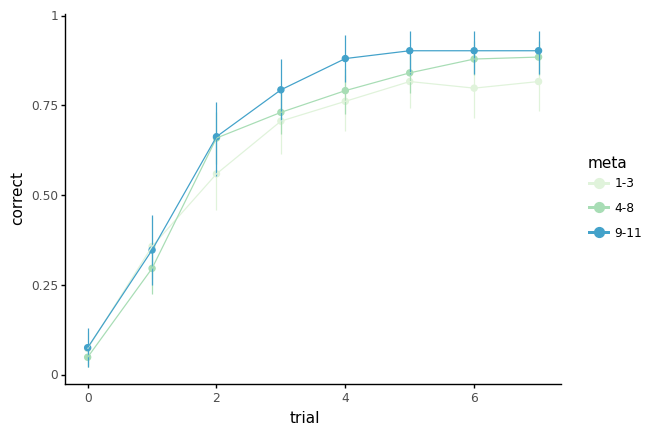

<ggplot: (128060284170)>

In [219]:
g = (gg.ggplot(gg.aes('trial', 'correct', color='meta', group='meta'), plot_dat_learn)
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.scale_color_brewer(type='seq', palette=4)
    )
g
g_s = (g
       + gg.facet_grid('agegroup ~ sex')
      )

g.save(os.path.join(plot_dir, '1E_SessionCorrect.png'), width=wihi, height=wihi)
g.save(os.path.join(plot_dir, '1E_SessionCorrect.svg'), width=wihi, height=wihi)
g_s.save(os.path.join(plot_dir, 'S1E_SessionCorrect.png'), width=2 * wihi, height=2 * wihi)
g_s.save(os.path.join(plot_dir, 'S1E_SessionCorrect.svg'), width=2 * wihi, height=2 * wihi)
g

In [220]:
smf.mixedlm(
    "correct ~ (trial + meta + sex + agegroup) * (trial + meta + sex + agegroup)",
    data=plot_dat_learn,
    groups=plot_dat_learn['animal']
).fit().summary()

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                    MixedLM       Dependent Variable:       correct   
No. Observations:         3064          Method:                   REML      
No. Groups:               38            Scale:                    0.1643    
Min. group size:          32            Log-Likelihood:           -1640.1010
Max. group size:          88            Converged:                Yes       
Mean group size:          80.6                                              
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.252    0.050  5.016 0.000  0.153  0.350
meta[T.4-8]                       -0.023    0.046 -0.496 0.620 -0.112  0.067
meta[T.9-11]                      -0.008    0.052 -0.162 0.871 -0.110  0.093
sex[T.Male]                       -0.007    0.054 -0.126 0.900 -0.113  0.099
agegroup[T.Juvenile]               0.053    0.053  0.992 0.321 -0.051  0.156
meta[T.4-8]:sex[T.Male]            0.095    0.036  2.620 0.009  0.024  0.165
meta[T.9-11]:sex[T.Male]           0.038    0.042  0.893 0.372 -0.045  0.121
meta[T.4-8]:agegroup[T.Juvenile]  -0.082    0.037 -2.181 0.029 -0.155 -0.008
meta[T.9-11]:agegroup[T.Juvenile]  0.019    0.043  0.449 0.653 -0.065  0.103
sex[T.Male]:agegroup[T.Juvenile]  -0.033    0.052 -0.621 0.535 -0.135  0.070
trial                              0.094    0.008 11.081 0.000  0.077  0.110
trial:meta[T.4-8]                  0.014    0.008  1.793 0.073 -0.001  0.028
trial:meta[T.9-11]                 0.014    0.009  1.565 0.118 -0.004  0.031
trial:sex[T.Male]                  0.003    0.007  0.387 0.699 -0.010  0.016
trial:agegroup[T.Juvenile]         0.004    0.007  0.611 0.541 -0.009  0.017
Group Var                          0.004    0.003                           
============================================================================

"""

In [317]:
# def sigmoid(x, L, x0, beta, bias):
#     return L / (1 + np.exp(-beta * (x - x0))) + bias

# # Test
# sigmoid(x=3, L=1, x0=0.5, beta=4, bias=0)

In [318]:
# def fit_sigmoid_to_one_dataset(xs, ys, p0):

#     y_pred = []
#     p_opts = np.empty([0, 4])

#     popt, pcov = curve_fit(sigmoid, xs, ys, p0, method='dogbox', maxfev=1e9)
#     y_pred += list(sigmoid(xs, *popt))
#     p_opts = np.vstack([
#         p_opts,
#         np.tile(popt, len(xdata)).reshape([len(xdata), len(popt)])
#     ])
    
#     result = pd.DataFrame({'y_pred': y_pred})
#     for col_i, col_name in enumerate(['L', 'x0', 'beta', 'bias']):
#         result[col_name] = p_opts[:, col_i]
    
#     return result

In [319]:
# # Test fit_sigmoid_to_one_dataset(xs, ys, p0)

# p0 = [1, np.median(xdata), 1, 0]  # mandatory initial guess
# sub_dat = plot_dat_learn[
#     (plot_dat_learn['animal'] == plot_dat_learn['animal'][0])
#     & (plot_dat_learn['meta'] == '1-3')
# ].groupby(['meta', 'trial']).aggregate('mean').reset_index()

# fit_sigmoid_to_one_dataset(sub_dat['trial'], sub_dat['correct'], p0)


# # # Another test
# # p0 = [1, np.median(xdata), 1, 0]  # mandatory initial guess
# # results = pd.DataFrame(columns=fit_sigmoid_to_one_dataset(sub_dat['trial'], sub_dat['correct'], p0).columns)

# # for animal in np.unique(plot_dat_learn['animal'])[2:4]:
# #     print(animal)
# #     for meta in np.unique(plot_dat_learn['meta'])[:2]:
# #         print(meta)
        
# #         # Get data from one animal from one "meta" conglomerate
# #         sub_dat = plot_dat_learn[
# #             (plot_dat_learn['animal'] == animal) &
# #             (plot_dat_learn['meta'] == meta)
# #         ]
            
# #         # Average these data to get sigmoid learning curves
# #         mean_dat = sub_dat.groupby(['trial']).aggregate('mean').reset_index()
# #         trial = mean_dat['trial']
# #         correct = mean_dat['correct']
        
# #         # Fit sigmoid to this dataset
# #         result = fit_sigmoid_to_one_dataset(
# #             xs=trial,
# #             ys=correct,
# #             p0=p0,
# #         )
# #         result['animal'] = animal
# #         result['meta'] = meta
# #         result['trial'] = trial
# #         result['correct'] = correct
        
# #         # Save results to big dataframe
# #         results = results.append(result)
        
# # results

In [320]:
# # Fit sigmoid to all mice

# p0 = [1, np.median(xdata), 1, 0]  # mandatory initial guess
# results = pd.DataFrame(columns=fit_sigmoid_to_one_dataset(sub_dat['trial'], sub_dat['correct'], p0).columns)

# for animal in np.unique(plot_dat_learn['animal']):
#     print('mouse', animal)
#     for meta in np.unique(plot_dat_learn['meta']):
#         print('\t meta', meta)
        
#         # Get data from one animal from one "meta" conglomerate
#         sub_dat = plot_dat_learn[
#             (plot_dat_learn['animal'] == animal) &
#             (plot_dat_learn['meta'] == meta)
#         ].reset_index()
            
#         # Average these data to get sigmoid learning curves
#         mean_dat = sub_dat.groupby(['trial']).aggregate('mean').reset_index()
#         trial = mean_dat['trial']
#         correct = mean_dat['correct']
        
#         # Fit sigmoid to this dataset
#         if (len(trial) > 0) & (len(correct) > 0):
#             result = fit_sigmoid_to_one_dataset(
#                 xs=trial,
#                 ys=correct,
#                 p0=p0,
#             )
#             result['trial'] = trial
#             result['correct'] = correct
#             result['animal'] = animal
#             result['meta'] = meta
#             result['agegroup'] = sub_dat['agegroup'][0]
#             result['sex'] = sub_dat['sex'][0]
#             result['age'] = sub_dat['age'][0]

#             # Save results to big dataframe
#             results = results.append(result)
        
# results

In [321]:
# results.to_csv(os.path.join(mouse_data_dir, 'sigmoid_results.csv'), index=False)

In [322]:
results = pd.read_csv(os.path.join(mouse_data_dir, 'sigmoid_results.csv'))
results

,y_pred,L,x0,beta,bias,trial,correct,animal,meta,agegroup,sex,age
0,0.000013,0.799987,1.908399,17.568582,0.000013,0.0,0.000000,1.0,1-3,Adult,Male,75.0
1,0.000013,0.799987,1.908399,17.568582,0.000013,1.0,0.000000,1.0,1-3,Adult,Male,75.0
2,0.666654,0.799987,1.908399,17.568582,0.000013,2.0,0.666667,1.0,1-3,Adult,Male,75.0
3,0.800000,0.799987,1.908399,17.568582,0.000013,3.0,1.000000,1.0,1-3,Adult,Male,75.0
4,0.800000,0.799987,1.908399,17.568582,0.000013,4.0,1.000000,1.0,1-3,Adult,Male,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.633492,2.499519,-0.112084,0.401127,-1.308666,3.0,0.000000,38.0,9-11,Juvenile,Male,60.0
884,0.787978,2.499519,-0.112084,0.401127,-1.308666,4.0,1.000000,38.0,9-11,Juvenile,Male,60.0
885,0.905927,2.499519,-0.112084,0.401127,-1.308666,5.0,1.000000,38.0,9-11,Juvenile,Male,60.0
886,0.992609,2.499519,-0.112084,0.401127,-1.308666,6.0,1.000000,38.0,9-11,Juvenile,Male,60.0


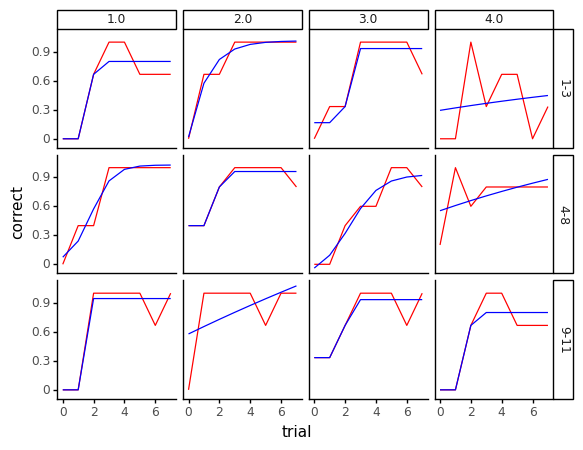

<ggplot: (128062422125)>

In [323]:
# Vizualize fit

example_dat = results[results['animal'] < 5]

g = (gg.ggplot(gg.aes('trial', 'correct'), example_dat)
     + gg.geom_line(gg.aes(y='correct'), color='red')
     + gg.geom_line(gg.aes(y='y_pred'), color='blue')
     + gg.facet_grid('meta ~ animal')
    )
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 1004'. Pick better value with 'binwidth'.


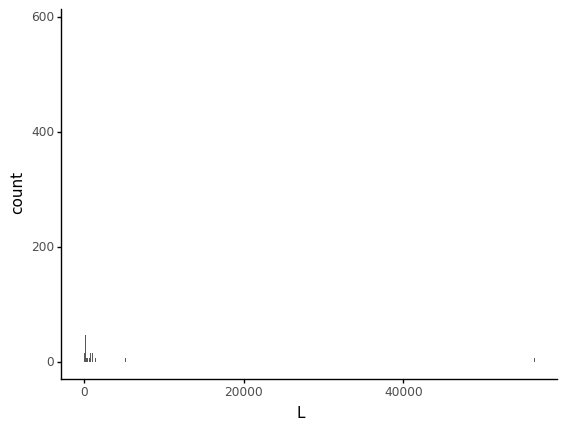

<ggplot: (128053251103)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 62'. Pick better value with 'binwidth'.


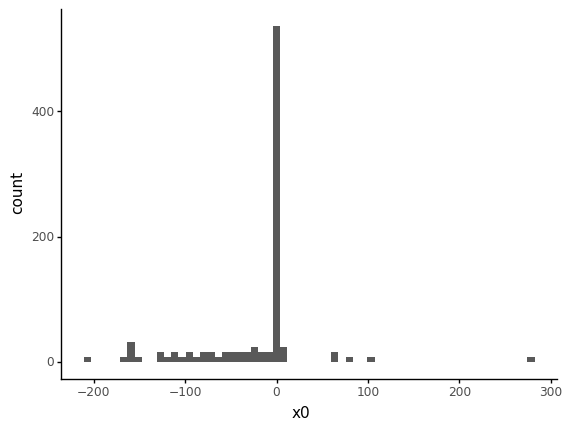

<ggplot: (128062458531)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


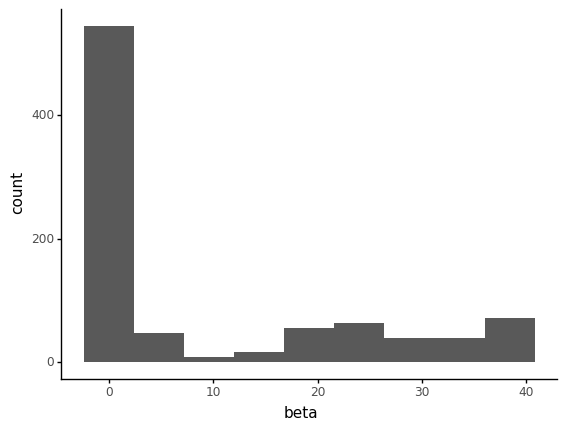

<ggplot: (128062461395)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 1533'. Pick better value with 'binwidth'.


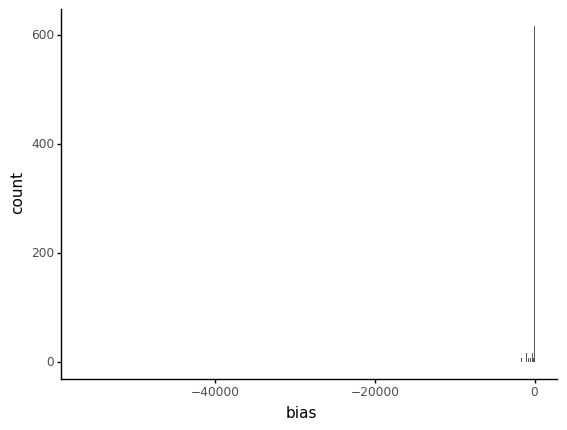

<ggplot: (128060244730)>


In [282]:
for y in ['L', 'x0', 'beta', 'bias']:
    print(gg.ggplot(gg.aes(y), results)
         + gg.geom_histogram()
        )

In [294]:
results = results.drop(results[results['L'] > 2000].index)
results = results.drop(results[results['bias'] < -2000].index)
results

,y_pred,L,x0,beta,bias,trial,correct,animal,meta,agegroup,sex,age
0,0.000013,0.799987,1.908399,17.568582,0.000013,0.0,0.000000,1.0,1-3,Adult,Male,75.0
1,0.000013,0.799987,1.908399,17.568582,0.000013,1.0,0.000000,1.0,1-3,Adult,Male,75.0
2,0.666654,0.799987,1.908399,17.568582,0.000013,2.0,0.666667,1.0,1-3,Adult,Male,75.0
3,0.800000,0.799987,1.908399,17.568582,0.000013,3.0,1.000000,1.0,1-3,Adult,Male,75.0
4,0.800000,0.799987,1.908399,17.568582,0.000013,4.0,1.000000,1.0,1-3,Adult,Male,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.633492,2.499519,-0.112084,0.401127,-1.308666,3.0,0.000000,38.0,9-11,Juvenile,Male,60.0
884,0.787978,2.499519,-0.112084,0.401127,-1.308666,4.0,1.000000,38.0,9-11,Juvenile,Male,60.0
885,0.905927,2.499519,-0.112084,0.401127,-1.308666,5.0,1.000000,38.0,9-11,Juvenile,Male,60.0
886,0.992609,2.499519,-0.112084,0.401127,-1.308666,6.0,1.000000,38.0,9-11,Juvenile,Male,60.0


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 49'. Pick better value with 'binwidth'.


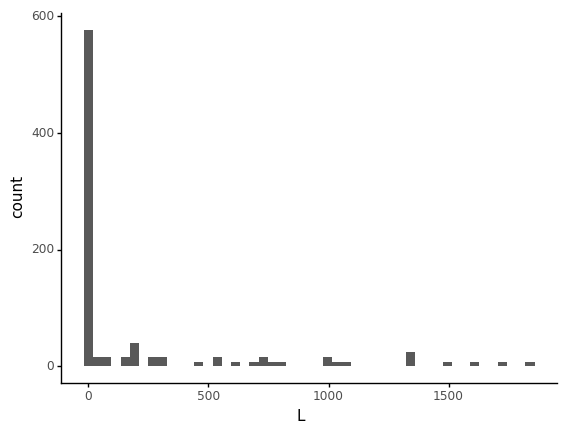

<ggplot: (128062252418)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 54'. Pick better value with 'binwidth'.


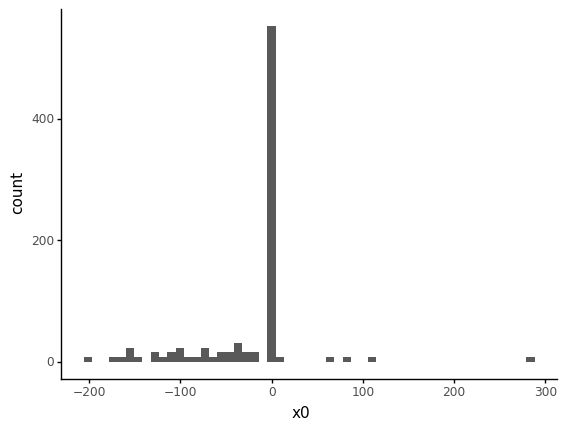

<ggplot: (128058471048)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


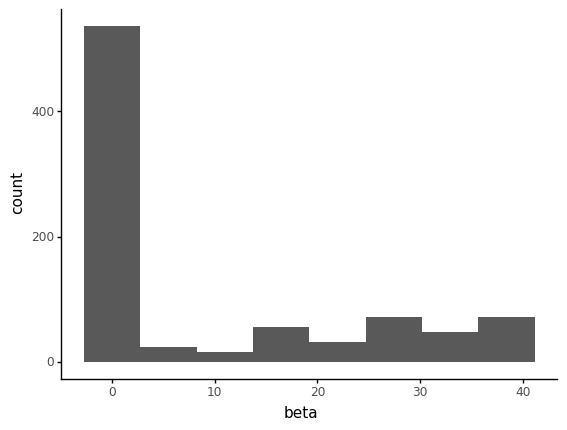

<ggplot: (128052632176)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 52'. Pick better value with 'binwidth'.


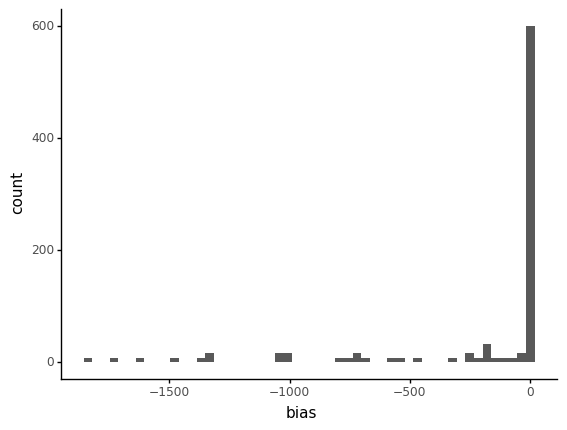

<ggplot: (128167380378)>


In [295]:
for y in ['L', 'x0', 'beta', 'bias']:
    print(gg.ggplot(gg.aes(y), results)
         + gg.geom_histogram()
        )

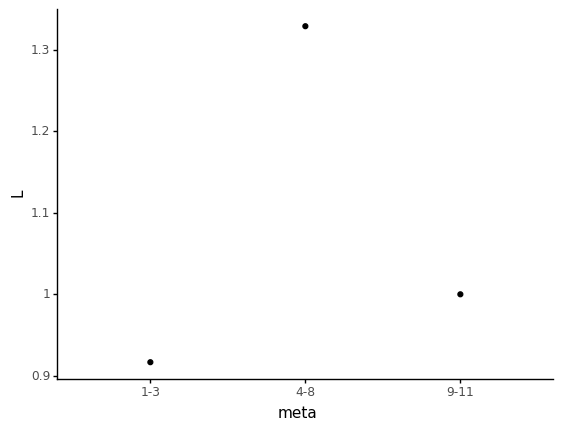

<ggplot: (128052565974)>


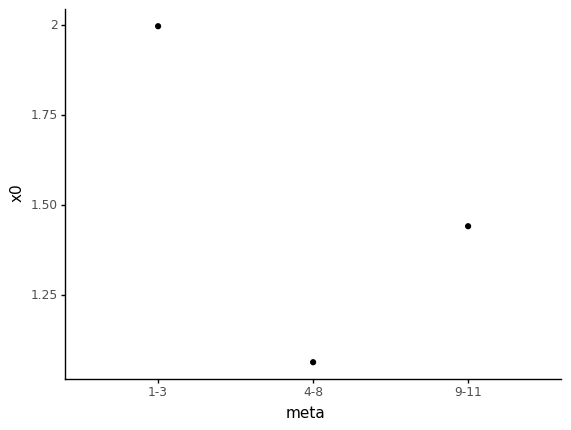

<ggplot: (128059643944)>


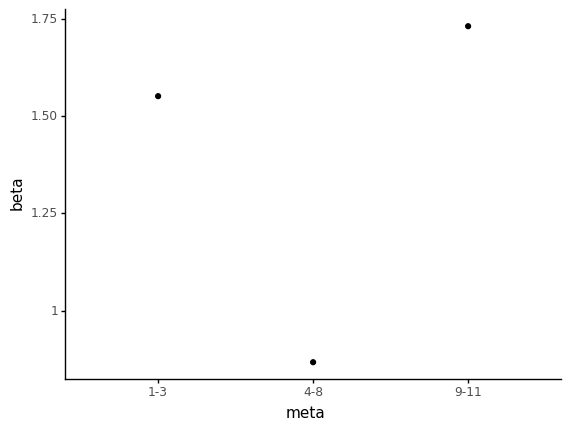

<ggplot: (128058471382)>


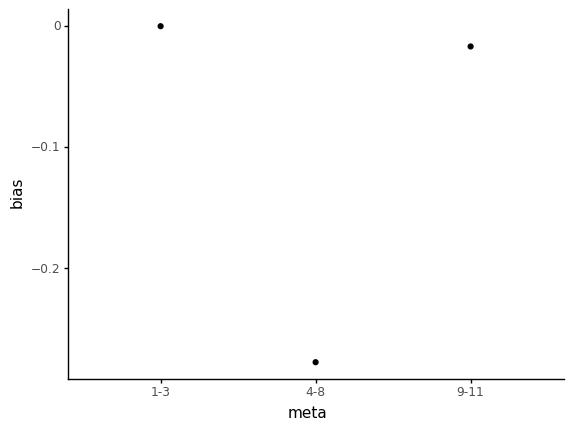

<ggplot: (128059847611)>


In [316]:
# Look at how sigmoid coefficients change with session

for y in ['L', 'x0', 'beta', 'bias']:
    print(gg.ggplot(gg.aes('meta', y), results)
#           + gg.stat_summary(fun_data='median_hilow')  # 'mean_cl_normal'
          + gg.stat_summary(fun_y=np.median, geom='point')
#      + gg.geom_point(position='jitter', alpha=0.2)
    )

In [298]:
# Do the stats

for y in ['L', 'x0', 'beta', 'bias']:
    print(smf.mixedlm(
        "L ~ (meta + sex + agegroup) * (meta + sex + agegroup)",
        data=results,
        groups=results['animal']
    ).fit().summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         L          
No. Observations:          856             Method:                     REML       
No. Groups:                38              Scale:                      120386.2711
Min. group size:           8               Log-Likelihood:             -6216.2191 
Max. group size:           24              Converged:                  Yes        
Mean group size:           22.5                                                   
----------------------------------------------------------------------------------
                                    Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
----------------------------------------------------------------------------------
Intercept                           131.894  116.394  1.133 0.257  -96.235 360.022
meta[T.4-8]                          62.361   58.578  1.065 0.287  -52.450 177.172
meta[T.9-11]               

## Performance over sessions

In [26]:
# Summarize data for regression
plot_dat_meta = true_dat.groupby(['fullID']).mean().reset_index()
plot_dat_meta['sex'] = plot_dat_meta.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
plot_dat_meta['agegroup'] = plot_dat_meta.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
plot_dat_meta['meta'] = add_meta_column(plot_dat_meta)
plot_dat_meta

,fullID,action,reward,rt,correct,trial,block,age,animal,rew_1ago,...,block_length,block_trial,trials2switch,session,switch,stay,excluded,sex,agegroup,meta
0,107511,0.478,0.624,0.549021,0.808,249.5,10.910,75.0,1.0,0.623246,...,24.652,11.586,8.676,0.0,0.152,0.848,0.0,Male,Adult,1-3
1,107611,0.488,0.600,0.604154,0.800,249.5,10.036,76.0,1.0,0.599198,...,28.846,13.878,10.968,1.0,0.138,0.862,0.0,Male,Adult,1-3
2,107711,0.496,0.556,0.618402,0.754,249.5,8.394,77.0,1.0,0.557114,...,30.112,14.150,11.234,2.0,0.198,0.802,0.0,Male,Adult,1-3
3,107811,0.462,0.634,0.577609,0.818,249.5,8.940,78.0,1.0,0.633267,...,27.680,13.120,10.252,3.0,0.190,0.810,0.0,Male,Adult,4-8
4,107911,0.480,0.646,0.522812,0.834,249.5,9.602,79.0,1.0,0.645291,...,26.224,12.560,9.572,4.0,0.120,0.880,0.0,Male,Adult,4-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,3805212,0.494,0.620,0.798950,0.804,249.5,9.546,52.0,38.0,0.619238,...,27.872,13.276,10.324,4.0,0.216,0.784,0.0,Male,Juvenile,4-8
379,3805412,0.504,0.606,0.737551,0.794,249.5,11.698,54.0,38.0,0.605210,...,24.912,11.696,8.774,5.0,0.154,0.846,0.0,Male,Juvenile,4-8
380,3805612,0.564,0.590,1.190926,0.774,249.5,11.750,56.0,38.0,0.591182,...,23.362,11.012,8.090,6.0,0.298,0.702,0.0,Male,Juvenile,4-8
381,3805812,0.508,0.586,0.659789,0.802,249.5,9.610,58.0,38.0,0.587174,...,25.826,12.128,9.218,7.0,0.132,0.868,0.0,Male,Juvenile,4-8


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1A_SessionCorrect.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1A_SessionCorrect.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 6 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\S1A_SessionCorrect.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: Plotn

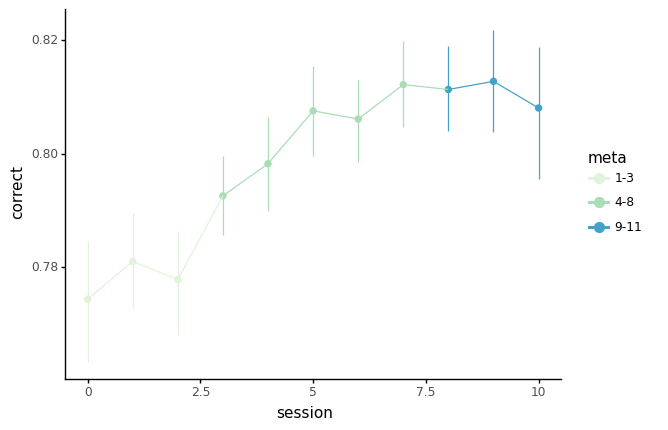

<ggplot: (128052910689)>

In [27]:
# Plot
g = (gg.ggplot(plot_dat_meta, gg.aes('session', 'correct', color='meta', group=1))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.scale_color_brewer(type='seq', palette=4)
)
g_s = (g
       + gg.facet_grid('agegroup ~ sex')
      )

g.save(os.path.join(plot_dir, '1A_SessionCorrect.png'), width=wihi, height=wihi)
g.save(os.path.join(plot_dir, '1A_SessionCorrect.svg'), width=wihi, height=wihi)
g_s.save(os.path.join(plot_dir, 'S1A_SessionCorrect.png'), width=2 * wihi, height=2 * wihi)
g_s.save(os.path.join(plot_dir, 'S1A_SessionCorrect.svg'), width=2 * wihi, height=2 * wihi)
g

In [28]:
smf.mixedlm(
    "correct ~ (session + sex + agegroup) * (session + sex + agegroup)",
    data=plot_dat_meta,
    groups=plot_dat_meta['animal']
).fit().summary()

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
============================================================================
Model:                    MixedLM        Dependent Variable:        correct 
No. Observations:         383            Method:                    REML    
No. Groups:               38             Scale:                     0.0005  
Min. group size:          4              Log-Likelihood:            845.6652
Max. group size:          11             Converged:                 Yes     
Mean group size:          10.1                                              
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.770    0.007 107.947 0.000  0.756  0.784
sex[T.Male]                       0.008    0.009   0.924 0.355 -0.009  0.026
agegroup[T.Juvenile]             -0.001    0.009  -0.061 0.951 -0.017  0.016
sex[T.Male]:agegroup[T.Juvenile]  0.006    0.010   0.562 0.574 -0.014  0.025
session                           0.005    0.001   6.281 0.000  0.003  0.006
session:sex[T.Male]               0.000    0.001   0.248 0.804 -0.001  0.002
session:agegroup[T.Juvenile]     -0.001    0.001  -1.467 0.142 -0.003  0.000
Group Var                         0.000    0.002                            
============================================================================

"""

In [57]:
# # Simple model based on mean data (1 data point per mouse per session)
# print(smf.ols(
#     "correct ~ (session + sex + agegroup) * (session + sex + agegroup)",
#     mean_dat,
# ).fit().summary())

In [58]:
# # Mixed-effects model based on all data (500 trials per animal per session)
# # PROBLEM: I WANT TO RUN A LOGIT MODEL, NOT LINEAR REGRESSION; CORRECT IS BINARY
# print(smf.mixedlm(
#     "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
#     true_dat,
#     groups=true_dat["animal"]  # Default random effects structure: random intercept for each group
# ).fit().summary())

In [59]:
# # from statsmodels.formula.api import logit
# # PROBLEM: I WANT TO RUN A MIXED-EFFECTS MODEL, NOT FLAT; TRIALS ARE NESTED WITHIN ANIMALS
# print(smf.logit(
#     "correct ~ (block + session + sex + agegroup) * (block + session + sex + agegroup)",
#     true_dat,
# ).fit().summary())

In [60]:
# # Post-hoc t-tests
# print("\nTesting differences between juveniles and adults:")
# for sex in np.unique(mean_dat.sex):
#     for meta in np.unique(mean_dat.meta):
        
#         sub_dat = mean_dat[(mean_dat.meta == meta) * (mean_dat.sex == sex)]
#         t, p = scipy.stats.ttest_ind(
#             sub_dat.correct[sub_dat.agegroup == 'Juvenile'],
#             sub_dat.correct[sub_dat.agegroup == 'Adult']
#         )
#         print("\t{}s, sessions {}: t={}, p={}".format(sex, meta, round(t, 1), round(p, 4)))

## Agegroup differences in switch speed?

In [82]:
# Get data
plot_dat_switchspeed = true_dat.groupby(['animal', 'agegroup', 'sex', 'meta', 'trials2switch']).aggregate('mean').reset_index().dropna()
plot_dat_switchspeed = plot_dat_switchspeed[plot_dat_switchspeed['trials2switch'].isin(range(6))]
plot_dat_switchspeed

,animal,agegroup,sex,meta,trials2switch,action,reward,rt,correct,trial,...,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,session,switch,stay,excluded
375,1,Adult,Male,1-3,0.0,0.532258,0.016129,0.572580,0.016129,239.193548,...,0.534483,0.500000,0.568966,0.534483,24.967742,0.0,0.935484,0.064516,0.935484,0.0
376,1,Adult,Male,1-3,1.0,0.564516,0.129032,0.526242,0.177419,240.193548,...,0.465517,0.534483,0.500000,0.568966,24.967742,1.0,0.935484,0.161290,0.838710,0.0
377,1,Adult,Male,1-3,2.0,0.580645,0.403226,0.646815,0.516129,241.193548,...,0.482759,0.465517,0.534483,0.500000,24.967742,2.0,0.935484,0.403226,0.596774,0.0
378,1,Adult,Male,1-3,3.0,0.435484,0.596774,0.639484,0.758065,242.193548,...,0.431034,0.482759,0.465517,0.534483,24.967742,3.0,0.935484,0.435484,0.564516,0.0
379,1,Adult,Male,1-3,4.0,0.467742,0.725806,0.617154,0.887097,243.193548,...,0.413793,0.431034,0.482759,0.465517,24.967742,4.0,0.935484,0.193548,0.806452,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27656,38,Juvenile,Male,9-11,1.0,0.681818,0.045455,0.603939,0.181818,264.000000,...,0.476190,0.476190,0.476190,0.428571,23.409091,1.0,8.000000,0.181818,0.818182,0.0
27657,38,Juvenile,Male,9-11,2.0,0.500000,0.409091,0.705815,0.727273,265.000000,...,0.476190,0.476190,0.476190,0.476190,23.409091,2.0,8.000000,0.818182,0.181818,0.0
27658,38,Juvenile,Male,9-11,3.0,0.476190,0.619048,0.870414,0.714286,254.857143,...,0.550000,0.500000,0.500000,0.450000,23.666667,3.0,8.000000,0.380952,0.619048,0.0
27659,38,Juvenile,Male,9-11,4.0,0.476190,0.904762,0.916856,0.904762,255.857143,...,0.400000,0.550000,0.500000,0.500000,23.666667,4.0,8.000000,0.285714,0.714286,0.0


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scales.py:29: PlotnineWarning: Scale for 'color' is already present.
Adding another scale for 'color',
which will replace the existing scale.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1B_MetaSwitchSpeed.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1B_MetaSwitchSpeed.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 6 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-pa

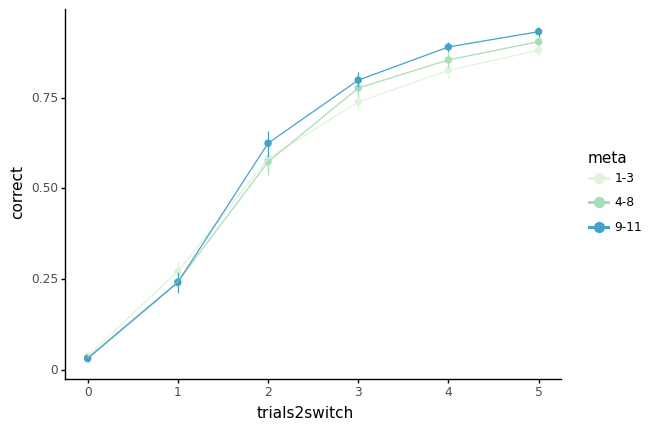

<ggplot: (176270333928)>

In [83]:
# Plot
g = (gg.ggplot(plot_dat_switchspeed, gg.aes('trials2switch', 'correct', color='meta', group='meta'))
    + gg.stat_summary()
    + gg.stat_summary(geom='line')
    + gg.scale_color_brewer(type='seq', palette=4)
#     + gg.geom_vline(xintercept=0, linetype='dotted')
)

g_s = (g
       + gg.scale_color_brewer()
       + gg.facet_grid('agegroup ~ sex')
      )

g.save(os.path.join(plot_dir, '1B_MetaSwitchSpeed.png'), width=wihi, height=wihi)
g.save(os.path.join(plot_dir, '1B_MetaSwitchSpeed.svg'), width=wihi, height=wihi)
g_s.save(os.path.join(plot_dir, 'S1B_MetaSwitchSpeed.png'), width=2 * wihi, height=2 * wihi)
g_s.save(os.path.join(plot_dir, 'S1B_MetaSwitchSpeed.svg'), width=2 * wihi, height=2 * wihi)
g

In [34]:
# Get data
regr_dat_switchspeed = true_dat.groupby(['animal', 'agegroup', 'sex', 'session', 'trials2switch']).aggregate('mean').reset_index().dropna()
regr_dat_switchspeed

,animal,agegroup,sex,session,trials2switch,action,reward,rt,correct,trial,...,act_15ago,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,switch,excluded,stay
1364,1,Adult,Male,0.0,-3.0,0.500000,0.681818,0.517887,1.000000,249.045455,...,0.500000,0.681818,0.590909,0.500000,0.571429,22.045455,19.045455,0.045455,0.0,0.954545
1365,1,Adult,Male,0.0,-2.0,0.500000,0.818182,0.517977,1.000000,250.045455,...,0.454545,0.500000,0.681818,0.590909,0.500000,22.045455,20.045455,0.000000,0.0,1.000000
1366,1,Adult,Male,0.0,-1.0,0.500000,0.954545,0.476864,1.000000,251.045455,...,0.636364,0.454545,0.500000,0.681818,0.590909,22.045455,21.045455,0.000000,0.0,1.000000
1367,1,Adult,Male,0.0,0.0,0.521739,0.000000,0.505196,0.000000,241.086957,...,0.500000,0.636364,0.454545,0.500000,0.681818,22.434783,0.000000,0.043478,0.0,0.956522
1368,1,Adult,Male,0.0,1.0,0.565217,0.173913,0.402913,0.217391,242.086957,...,0.545455,0.500000,0.636364,0.454545,0.500000,22.434783,1.000000,0.217391,0.0,0.782609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101462,38,Juvenile,Male,8.0,27.0,0.600000,1.000000,1.152532,1.000000,191.800000,...,0.800000,0.600000,0.800000,0.600000,0.600000,33.800000,27.000000,0.000000,0.0,1.000000
101463,38,Juvenile,Male,8.0,28.0,0.750000,0.750000,0.534833,1.000000,206.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,34.500000,28.000000,0.000000,0.0,1.000000
101464,38,Juvenile,Male,8.0,29.0,0.750000,0.500000,0.483168,1.000000,207.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,34.500000,29.000000,0.000000,0.0,1.000000
101465,38,Juvenile,Male,8.0,30.0,0.666667,0.666667,1.301990,1.000000,258.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,35.000000,30.000000,0.000000,0.0,1.000000


In [35]:
sub_dat = regr_dat_switchspeed.loc[
    (regr_dat_switchspeed['trials2switch'] == 3)
]
sub_dat

,animal,agegroup,sex,session,trials2switch,action,reward,rt,correct,trial,...,act_15ago,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,switch,excluded,stay
1370,1,Adult,Male,0.0,3.0,0.434783,0.478261,0.731674,0.695652,244.086957,...,0.545455,0.409091,0.545455,0.500000,0.636364,22.434783,3.0,0.434783,0.0,0.565217
1432,1,Adult,Male,1.0,3.0,0.400000,0.550000,0.617350,0.800000,227.100000,...,0.277778,0.444444,0.444444,0.388889,0.444444,25.150000,3.0,0.450000,0.0,0.550000
1494,1,Adult,Male,2.0,3.0,0.473684,0.789474,0.551184,0.789474,255.789474,...,0.388889,0.444444,0.444444,0.500000,0.500000,27.842105,3.0,0.421053,0.0,0.578947
1556,1,Adult,Male,3.0,3.0,0.500000,0.900000,0.644025,1.000000,254.500000,...,0.473684,0.315789,0.210526,0.263158,0.421053,25.500000,3.0,0.200000,0.0,0.800000
1618,1,Adult,Male,4.0,3.0,0.500000,0.600000,0.646675,0.700000,238.050000,...,0.421053,0.368421,0.421053,0.368421,0.421053,24.900000,3.0,0.300000,0.0,0.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101190,38,Juvenile,Male,4.0,3.0,0.571429,0.857143,0.676310,0.904762,251.904762,...,0.550000,0.400000,0.450000,0.550000,0.450000,24.761905,3.0,0.476190,0.0,0.523810
101252,38,Juvenile,Male,5.0,3.0,0.500000,0.708333,0.858362,0.750000,238.458333,...,0.565217,0.478261,0.409091,0.409091,0.409091,21.666667,3.0,0.416667,0.0,0.583333
101314,38,Juvenile,Male,6.0,3.0,0.500000,0.625000,1.023667,0.750000,237.375000,...,0.652174,0.478261,0.478261,0.608696,0.565217,21.375000,3.0,0.333333,0.0,0.666667
101376,38,Juvenile,Male,7.0,3.0,0.521739,0.695652,0.800761,0.869565,272.347826,...,0.545455,0.454545,0.454545,0.500000,0.545455,22.565217,3.0,0.434783,0.0,0.565217


In [36]:
smf.mixedlm(
    'correct ~ (agegroup + sex + session) * (agegroup + sex + session)',
    data=sub_dat,
    groups=sub_dat['animal']
).fit().summary()

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
==========================================================================
Model:                    MixedLM       Dependent Variable:       correct 
No. Observations:         383           Method:                   REML    
No. Groups:               38            Scale:                    0.0104  
Min. group size:          4             Log-Likelihood:           288.3919
Max. group size:          11            Converged:                Yes     
Mean group size:          10.1                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.767    0.017 44.210 0.000  0.733  0.801
agegroup[T.Adult]               -0.070    0.029 -2.396 0.017 -0.128 -0.013
sex[T.Female]                   -0.019    0.027 -0.685 0.493 -0.072  0.035
agegroup[T.Adult]:sex[T.Female]  0.023    0.036  0.627 0.530 -0.048  0.094
session                          0.005    0.003  2.055 0.040  0.000  0.010
agegroup[T.Adult]:session        0.004    0.004  1.016 0.309 -0.003  0.011
sex[T.Female]:session            0.000    0.004  0.135 0.893 -0.006  0.007
Group Var                        0.002    0.007                           
==========================================================================

"""

## Asymptotic performance

In [87]:
plot_dat_asymp = true_dat.loc[
    (true_dat['trials2switch'] >= 7) & (true_dat['trials2switch'] <= 12)
].groupby(['animal', 'agegroup', 'sex', 'meta', 'trials2switch']).aggregate('mean').reset_index().dropna()
plot_dat_asymp

,animal,agegroup,sex,meta,trials2switch,action,reward,rt,correct,trial,...,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,session,switch,stay,excluded
36,1,Adult,Male,1-3,7.0,0.525424,0.576271,0.505899,0.898305,251.576271,...,0.508772,0.491228,0.446429,0.410714,25.728814,7.0,0.949153,0.118644,0.881356,0.0
37,1,Adult,Male,1-3,8.0,0.482759,0.568966,0.612086,0.844828,252.620690,...,0.464286,0.500000,0.482143,0.436364,25.982759,8.0,0.931034,0.189655,0.810345,0.0
38,1,Adult,Male,1-3,9.0,0.500000,0.607143,0.544384,0.892857,256.910714,...,0.407407,0.462963,0.500000,0.481481,26.482143,9.0,0.964286,0.232143,0.767857,0.0
39,1,Adult,Male,1-3,10.0,0.472727,0.654545,0.559336,0.872727,260.436364,...,0.433962,0.415094,0.471698,0.509434,26.727273,10.0,0.963636,0.127273,0.872727,0.0
40,1,Adult,Male,1-3,11.0,0.528302,0.603774,0.562311,0.811321,260.396226,...,0.509804,0.431373,0.411765,0.470588,27.207547,11.0,1.000000,0.132075,0.867925,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,38,Juvenile,Male,9-11,8.0,0.473684,0.789474,0.592878,1.000000,252.789474,...,0.444444,0.444444,0.611111,0.555556,25.105263,8.0,8.000000,0.157895,0.842105,0.0
2678,38,Juvenile,Male,9-11,9.0,0.500000,0.555556,0.571963,0.888889,263.944444,...,0.529412,0.411765,0.411765,0.588235,25.833333,9.0,8.000000,0.111111,0.888889,0.0
2679,38,Juvenile,Male,9-11,10.0,0.555556,0.777778,0.747556,0.833333,264.944444,...,0.529412,0.529412,0.411765,0.411765,25.833333,10.0,8.000000,0.277778,0.722222,0.0
2680,38,Juvenile,Male,9-11,11.0,0.555556,0.833333,0.523035,0.944444,265.944444,...,0.529412,0.529412,0.529412,0.411765,25.833333,11.0,8.000000,0.111111,0.888889,0.0


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1C_AsymptoticPerformance.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1C_AsymptoticPerformance.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 6 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\S1C_AsymptoticPerformance.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine

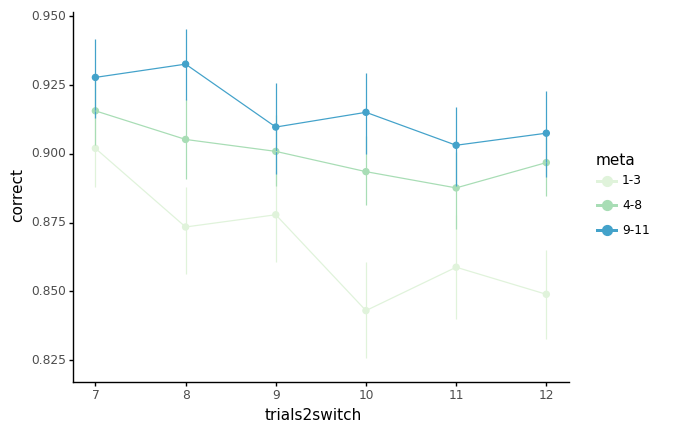

<ggplot: (176270665671)>

In [93]:
# g = (gg.ggplot(plot_dat_asymp, gg.aes('meta', 'correct', group=1))
#      + gg.stat_summary()
#      + gg.stat_summary(geom='line')
#     )

# g_s = (g
#        + gg.aes(color='agegroup', group='agegroup')
#        + gg.facet_grid('~ sex')
#       )

g = (gg.ggplot(plot_dat_asymp, gg.aes('trials2switch', 'correct', color='meta', group='meta'))
     + gg.stat_summary()
     + gg.scale_color_brewer(type='seq', palette=4)
     + gg.stat_summary(geom='line')
    )

g_s = (g
       + gg.facet_grid('agegroup ~ sex')
      )

g.save(os.path.join(plot_dir, '1C_AsymptoticPerformance.png'), width=wihi, height=wihi)
g.save(os.path.join(plot_dir, '1C_AsymptoticPerformance.svg'), width=wihi, height=wihi)
g_s.save(os.path.join(plot_dir, 'S1C_AsymptoticPerformance.png'), width=2 * wihi, height=2 * wihi)
g_s.save(os.path.join(plot_dir, 'S1C_AsymptoticPerformance.svg'), width=2 * wihi, height=2 * wihi)
g

In [39]:
regr_dat_asympt = true_dat.loc[
    (true_dat['trials2switch'] >= 7) & (true_dat['trials2switch'] <= 12)
].groupby(['animal', 'agegroup', 'sex', 'session']).aggregate('mean').reset_index().dropna()
regr_dat_asympt

,animal,agegroup,sex,session,action,reward,rt,correct,trial,block,...,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,trials2switch,switch,excluded,stay
22,1,Adult,Male,0.0,0.420168,0.705882,0.547370,0.907563,261.924370,11.571429,...,0.477876,0.469027,0.451327,0.460177,24.109244,9.344538,9.344538,0.134454,0.0,0.865546
23,1,Adult,Male,1.0,0.509615,0.586538,0.574841,0.903846,244.817308,9.971154,...,0.442308,0.442308,0.427184,0.411765,27.346154,9.432692,9.432692,0.163462,0.0,0.836538
24,1,Adult,Male,2.0,0.541284,0.513761,0.554238,0.770642,262.761468,9.045872,...,0.485437,0.495146,0.495146,0.485437,28.614679,9.477064,9.477064,0.201835,0.0,0.798165
25,1,Adult,Male,3.0,0.424779,0.628319,0.565739,0.858407,264.548673,9.663717,...,0.504673,0.523364,0.514019,0.514019,26.256637,9.398230,9.398230,0.150442,0.0,0.849558
26,1,Adult,Male,4.0,0.460870,0.739130,0.473587,0.965217,246.834783,9.608696,...,0.431193,0.449541,0.477064,0.477064,25.504348,9.478261,9.478261,0.060870,0.0,0.939130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632,38,Juvenile,Male,4.0,0.542056,0.616822,0.786804,0.906542,258.224299,10.018692,...,0.594059,0.574257,0.554455,0.544554,26.261682,9.336449,9.336449,0.149533,0.0,0.850467
1633,38,Juvenile,Male,5.0,0.477876,0.601770,0.784932,0.902655,256.123894,12.115044,...,0.463636,0.427273,0.445455,0.481818,24.592920,9.256637,9.256637,0.132743,0.0,0.867257
1634,38,Juvenile,Male,6.0,0.539683,0.579365,1.240599,0.841270,254.500000,12.047619,...,0.600000,0.616667,0.583333,0.608333,22.809524,9.380952,9.380952,0.238095,0.0,0.761905
1635,38,Juvenile,Male,7.0,0.445378,0.663866,0.649828,0.907563,269.100840,10.605042,...,0.469027,0.477876,0.495575,0.504425,24.260504,9.344538,9.344538,0.100840,0.0,0.899160


In [40]:
smf.mixedlm(
    'correct ~ (agegroup + sex + session) * (agegroup + sex + session)',
    data=regre_dat_asympt,
    groups=regr_dat_asympt['animal']
).fit().summary()

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Mixed Linear Model Regression Results
===========================================================================
Model:                   MixedLM        Dependent Variable:        correct 
No. Observations:        383            Method:                    REML    
No. Groups:              38             Scale:                     0.0020  
Min. group size:         4              Log-Likelihood:            596.7346
Max. group size:         11             Converged:                 Yes     
Mean group size:         10.1                                              
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                        0.873    0.008 113.273 0.000  0.858  0.888
agegroup[T.Adult]                0.003    0.013   0.205 0.837 -0.023  0.028
sex[T.Female]                   -0.027    0.012  -2.263 0.024 -0.051 -0.004
agegroup[T.Adult]:sex[T.Female]  0.013    0.016   0.826 0.409 -0.018  0.045
session                          0.006    0.001   5.257 0.000  0.004  0.008
agegroup[T.Adult]:session        0.001    0.002   0.754 0.451 -0.002  0.004
sex[T.Female]:session           -0.000    0.002  -0.256 0.798 -0.003  0.003
Group Var                        0.000    0.003                            
===========================================================================

"""

## Reward history

In [94]:
# only trials in which the same action was executed twice in a row
sub_dat = true_dat.loc[
    true_dat['act_1&2ago'].isin(['11', '00'])
]
sub_dat

# average over meta-sessions and reward conditions
plot_dat_rewardhistory = sub_dat.groupby(['sex', 'animal', 'agegroup', 'meta', 'rew_1&2ago']).aggregate('mean').reset_index().dropna()
plot_dat_rewardhistory['rew_1&2ago'] = pd.Categorical(plot_dat_rewardhistory['rew_1&2ago'], ordered=True, categories=('00', '01', '10', '11'))
plot_dat_rewardhistory

,sex,animal,agegroup,meta,rew_1&2ago,action,reward,rt,correct,trial,...,act_17ago,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,switch,stay,excluded
12,Male,1,Adult,1-3,00,0.479070,0.465116,0.653507,0.618605,242.651163,...,0.477612,0.517413,0.502488,30.093023,10.702326,9.786047,1.106977,0.520930,0.479070,0.0
13,Male,1,Adult,1-3,01,0.537879,0.549242,0.520496,0.685606,260.893939,...,0.498084,0.457692,0.488462,27.030303,12.303030,9.284091,0.988636,0.155303,0.844697,0.0
14,Male,1,Adult,1-3,10,0.522472,0.769663,0.541525,0.938202,266.561798,...,0.482955,0.454545,0.480000,26.539326,15.797753,10.561798,0.949438,0.033708,0.966292,0.0
15,Male,1,Adult,1-3,11,0.452261,0.641541,0.551539,0.899497,251.140704,...,0.489655,0.499136,0.480969,26.882747,14.023451,10.659966,0.944724,0.020101,0.979899,0.0
16,Male,1,Adult,4-8,00,0.516923,0.415385,0.631097,0.550769,258.750769,...,0.503145,0.493711,0.496855,27.083077,10.120000,8.621538,5.089231,0.523077,0.476923,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,Female,35,Juvenile,4-8,11,0.530444,0.685243,0.498399,0.899897,248.352941,...,0.502101,0.504202,0.510526,26.165119,13.670795,9.859649,4.992776,0.037152,0.962848,0.0
1736,Female,35,Juvenile,9-11,00,0.426471,0.406863,0.928500,0.568627,245.794118,...,0.479798,0.426396,0.423469,28.024510,11.740196,10.377451,9.137255,0.539216,0.460784,0.0
1737,Female,35,Juvenile,9-11,01,0.500000,0.516949,0.638102,0.652542,249.131356,...,0.467249,0.475983,0.510917,26.165254,11.283898,7.783898,9.025424,0.233051,0.766949,0.0
1738,Female,35,Juvenile,9-11,10,0.548611,0.652778,0.571420,0.840278,245.395833,...,0.492857,0.514286,0.521429,25.416667,12.965278,8.493056,9.020833,0.104167,0.895833,0.0


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1D_RewardHistory.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 3 x 3 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\1D_RewardHistory.svg
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 6 x 6 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots_MetaMice\S1D_RewardHistory.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: Plotnine

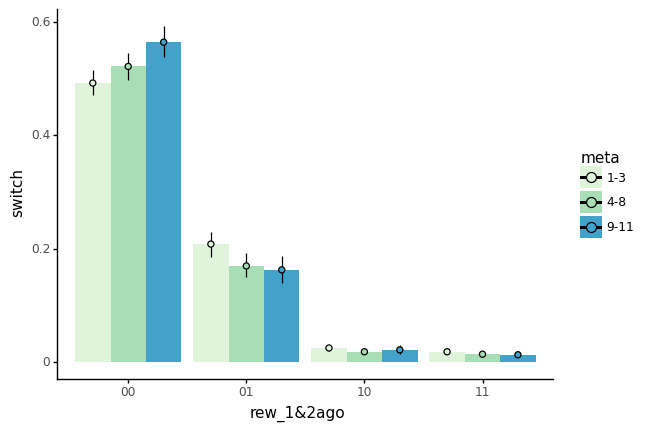

<ggplot: (176269168044)>

In [96]:
g = (gg.ggplot(plot_dat_rewardhistory, gg.aes('rew_1&2ago', 'switch', fill='meta', group='meta'))
     + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
     + gg.stat_summary(position=gg.position_dodge(width=0.9))
     + gg.scale_fill_brewer(type='seq', palette=4)
)

g_s = (g
     + gg.facet_grid('agegroup ~ sex')
      )

g.save(os.path.join(plot_dir, '1D_RewardHistory.png'), width=wihi, height=wihi)
g.save(os.path.join(plot_dir, '1D_RewardHistory.svg'), width=wihi, height=wihi)
g_s.save(os.path.join(plot_dir, 'S1D_RewardHistory.png'), width=2 * wihi, height=2 * wihi)
g_s.save(os.path.join(plot_dir, 'S1D_RewardHistory.svg'), width=2 * wihi, height=2 * wihi)
g

In [43]:
# average over meta-sessions and reward conditions
regr_dat_rewardhistory = sub_dat.groupby(['sex', 'animal', 'agegroup', 'session', 'rew_1&2ago']).aggregate('mean').reset_index().dropna()
regr_dat_rewardhistory

,sex,animal,agegroup,session,rew_1&2ago,action,reward,rt,correct,trial,...,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,trials2switch,switch,excluded,stay
44,Male,1,Adult,0.0,00,0.483333,0.466667,0.693300,0.650000,262.933333,...,0.423729,0.440678,0.508475,0.491525,25.816667,9.350000,8.016667,0.550000,0.0,0.450000
45,Male,1,Adult,0.0,01,0.511364,0.579545,0.407273,0.693182,265.875000,...,0.517241,0.494253,0.476744,0.500000,24.511364,11.295455,8.318182,0.147727,0.0,0.852273
46,Male,1,Adult,0.0,10,0.508475,0.779661,0.495746,0.915254,273.779661,...,0.517241,0.534483,0.431034,0.456140,23.627119,13.813559,9.118644,0.016949,0.0,0.983051
47,Male,1,Adult,0.0,11,0.439815,0.666667,0.519819,0.907407,241.643519,...,0.509709,0.502439,0.507317,0.478049,24.250000,12.458333,8.856481,0.013889,0.0,0.986111
48,Male,1,Adult,1.0,00,0.458333,0.472222,0.579195,0.597222,240.500000,...,0.462687,0.417910,0.477612,0.507463,30.819444,10.027778,9.055556,0.486111,0.0,0.513889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,Female,35,Juvenile,9.0,11,0.546961,0.679558,0.635724,0.861878,244.718232,...,0.483146,0.494382,0.477528,0.449438,25.160221,12.922652,8.657459,0.060773,0.0,0.939227
6376,Female,35,Juvenile,10.0,00,0.354430,0.329114,1.330506,0.493671,221.417722,...,0.441558,0.467532,0.428571,0.376623,26.962025,10.696203,8.810127,0.481013,0.0,0.518987
6377,Female,35,Juvenile,10.0,01,0.482353,0.552941,0.933965,0.635294,253.423529,...,0.535714,0.500000,0.464286,0.500000,24.105882,11.564706,7.600000,0.247059,0.0,0.752941
6378,Female,35,Juvenile,10.0,10,0.571429,0.632653,0.662327,0.836735,240.428571,...,0.571429,0.551020,0.530612,0.551020,23.489796,12.408163,7.000000,0.142857,0.0,0.857143


In [44]:
for rew in ['00', '01', '10', '11']:

    sub_dat = regr_dat_rewardhistory.loc[
        regr_dat_rewardhistory['rew_1&2ago'] == rew
    ]

    # Run model
    print("preward history: {}".format(rew))
    print(smf.mixedlm(
        'switch ~ (agegroup + sex + session) * (agegroup + sex + session)',
        data=sub_dat, groups=sub_dat['animal']
    ).fit().summary())

preward history: 00
                  Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       switch  
No. Observations:         383           Method:                   REML    
No. Groups:               38            Scale:                    0.0079  
Min. group size:          4             Log-Likelihood:           336.8936
Max. group size:          11            Converged:                Yes     
Mean group size:          10.1                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.515    0.016 31.366 0.000  0.483  0.547
agegroup[T.Adult]               -0.066    0.028 -2.341 0.019 -0.121 -0.011
sex[T.Female]                   -0.028    0.026 -1.066 0.287 -0.078  0.023
agegroup[T.Adult]:sex[T.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


preward history: 01
                  Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       switch  
No. Observations:         383           Method:                   REML    
No. Groups:               38            Scale:                    0.0052  
Min. group size:          4             Log-Likelihood:           403.7504
Max. group size:          11            Converged:                Yes     
Mean group size:          10.1                                            
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.223    0.016 13.820 0.000  0.191  0.254
agegroup[T.Adult]               -0.058    0.028 -2.070 0.038 -0.113 -0.003
sex[T.Female]                    0.009    0.026  0.328 0.743 -0.042  0.059
agegroup[T.Adult]:sex[T.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


In [111]:
# # Compare juvenlies to adults (males only; sessions 1-3 only)
# subj_dat = subj_dat.loc[
#     (subj_dat['sex'] == 'Male') & (subj_dat['meta'] == '1-3')
# ]

# for rew12 in ['01', '10']:
#     print('Reward history {}'.format(rew12))
#     sub_dat = subj_dat.loc[subj_dat['rew_1&2ago'] == rew12].rename(columns={'rew_1&2ago': 'rew12ago'}).dropna()
    
#     print(smf.mixedlm('switch ~ agegroup', data=sub_dat, groups=sub_dat['animal']).fit().summary())

In [112]:
# # t-test for the same comparison
# subj_dat = subj_dat.loc[
#     (subj_dat['sex'] == 'Male') & (subj_dat['meta'] == '1-3')
# ]

# for rew12 in ['01', '10']:
#     print('Reward history {}'.format(rew12))
#     sub_dat = subj_dat.loc[subj_dat['rew_1&2ago'] == rew12].rename(columns={'rew_1&2ago': 'rew12ago'}).dropna()
    
#     t, p = scipy.stats.ttest_ind(
#     sub_dat.switch[sub_dat.agegroup == 'Juvenile'],
#     sub_dat.switch[sub_dat.agegroup == 'Adult']
#     )
#     print(t.round(2), p.round(3))

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\pandas\core\computation\expressions.py:200: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 697060 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 697060 rows containing non-finite values.


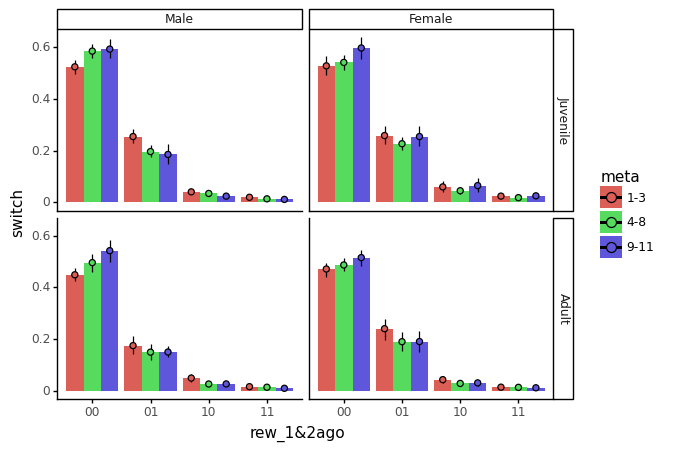

<ggplot: (181280424488)>

In [115]:
sub_dat = true_dat.loc[
    (true_dat['rew_1&2ago'] != '0n') * (true_dat['rew_1&2ago'] != '1n') * (true_dat['rew_1&2ago'] != 'nn')
]
subj_dat = sub_dat.groupby(['fullID', 'sex', 'animal', 'agegroup', 'meta', 'rew_1&2ago']).aggregate('mean').reset_index()

g = (gg.ggplot(subj_dat, gg.aes('rew_1&2ago', 'switch', fill='meta', group='meta'))
     + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
     + gg.stat_summary(position=gg.position_dodge(width=0.9))
     + gg.facet_grid('agegroup ~ sex')
)
g

In [116]:
sub_dat.loc[sub_dat['rew_1&2ago'] == rew12].dropna()

,fullID,sex,animal,agegroup,meta,rew_1&2ago,action,reward,rt,correct,...,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,trials2switch,session,excluded,switch
14,107511,Male,1,Adult,1-3,10,0.515789,0.757895,0.532553,0.915789,...,0.483871,0.494624,0.440860,0.467391,24.431579,12.094737,8.568421,0.0,False,0.042105
1838,107611,Male,1,Adult,1-3,10,0.514851,0.762376,0.630495,0.930693,...,0.494949,0.500000,0.479592,0.489796,28.564356,14.772277,11.089109,1.0,False,0.059406
3662,107711,Male,1,Adult,1-3,10,0.468085,0.702128,0.642404,0.925532,...,0.510870,0.467391,0.472527,0.538462,29.893617,14.978723,10.521277,2.0,False,0.053191
5490,107811,Male,1,Adult,4-8,10,0.449438,0.786517,0.623511,0.921348,...,0.406977,0.453488,0.465116,0.534884,27.471910,11.988764,10.134831,3.0,False,0.011236
7314,107911,Male,1,Adult,4-8,10,0.506024,0.759036,0.487825,0.951807,...,0.412500,0.450000,0.455696,0.430380,26.349398,12.759036,10.084337,4.0,False,0.012048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234690,1307921,Female,13,Adult,4-8,10,0.511628,0.744186,0.524547,0.930233,...,0.488095,0.547619,0.511905,0.506024,27.360465,13.186047,10.011628,6.0,False,0.023256
236514,1308021,Female,13,Adult,4-8,10,0.490196,0.676471,0.653873,0.911765,...,0.616162,0.581633,0.581633,0.591837,27.107843,12.127451,8.637255,7.0,False,0.009804
238342,1308121,Female,13,Adult,9-11,10,0.477778,0.833333,0.638572,0.966667,...,0.505882,0.559524,0.559524,0.488095,26.566667,14.144444,10.277778,8.0,False,0.044444
240166,1308221,Female,13,Adult,9-11,10,0.520000,0.720000,0.582080,0.940000,...,0.500000,0.453608,0.494845,0.500000,26.210000,12.890000,10.300000,9.0,False,0.020000


In [121]:
for rew12 in ['01', '10']:
    sub_dat = subj_dat.loc[
        (subj_dat['agegroup'] == 'Juvenile')
    ]
    sub_dat = sub_dat.loc[sub_dat['rew_1&2ago'] == rew12].dropna()
    sub_dat['meta_n'] = sub_dat['meta'].replace({'1-3': 1, '4-8': 2, '9-11': 3})
    print('history {}'.format(rew12))
    print(smf.mixedlm('switch ~ meta_n', data=sub_dat, groups=sub_dat['animal']).fit().summary())

history 01
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: switch  
No. Observations: 250     Method:             REML    
No. Groups:       25      Scale:              0.0059  
Min. group size:  4       Log-Likelihood:     253.7070
Max. group size:  11      Converged:          Yes     
Mean group size:  10.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.277    0.019 14.275 0.000  0.239  0.315
meta_n      -0.030    0.007 -4.287 0.000 -0.043 -0.016
Group Var    0.005    0.020                           



C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


history 10
        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: switch  
No. Observations: 250     Method:             REML    
No. Groups:       25      Scale:              0.0009  
Min. group size:  4       Log-Likelihood:     487.9444
Max. group size:  11      Converged:          Yes     
Mean group size:  10.0                                
------------------------------------------------------
            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------
Intercept    0.053    0.008  6.764 0.000  0.037  0.068
meta_n      -0.007    0.003 -2.470 0.014 -0.012 -0.001
Group Var    0.001    0.009                           



C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


## Sex differences in switch speed?

In [61]:
subj_dat = true_dat.groupby(['animal', 'agegroup', 'sex', 'meta', 'trials2switch']).aggregate('mean').reset_index().dropna()

# g = (gg.ggplot(subj_dat, gg.aes('trials2switch', 'correct', color='sex', group='sex'))
#  + gg.stat_summary()
#  + gg.stat_summary(geom='line')
#  + gg.coord_cartesian(xlim=(-3, 10))
#  + gg.facet_grid('~ meta')
# )
# g

In [125]:
sub_dat = subj_dat.loc[
    (subj_dat['trials2switch'] < 6) & (subj_dat['trials2switch'] >= 0)
]
sub_dat

,animal,agegroup,sex,meta,trials2switch,action,reward,rt,correct,trial,...,act_15ago,act_16ago,act_17ago,act_18ago,act_19ago,block_length,block_trial,session,excluded,switch
375,1,Adult,Male,1-3,0.0,0.532258,0.016129,0.572580,0.016129,239.193548,...,0.465517,0.534483,0.500000,0.568966,0.534483,24.967742,0.0,0.935484,False,0.064516
376,1,Adult,Male,1-3,1.0,0.564516,0.129032,0.526242,0.177419,240.193548,...,0.482759,0.465517,0.534483,0.500000,0.568966,24.967742,1.0,0.935484,False,0.161290
377,1,Adult,Male,1-3,2.0,0.580645,0.403226,0.646815,0.516129,241.193548,...,0.431034,0.482759,0.465517,0.534483,0.500000,24.967742,2.0,0.935484,False,0.403226
378,1,Adult,Male,1-3,3.0,0.435484,0.596774,0.639484,0.758065,242.193548,...,0.413793,0.431034,0.482759,0.465517,0.534483,24.967742,3.0,0.935484,False,0.435484
379,1,Adult,Male,1-3,4.0,0.467742,0.725806,0.617154,0.887097,243.193548,...,0.448276,0.413793,0.431034,0.482759,0.465517,24.967742,4.0,0.935484,False,0.193548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27656,38,Juvenile,Male,9-11,1.0,0.681818,0.045455,0.603939,0.181818,264.000000,...,0.476190,0.476190,0.476190,0.476190,0.428571,23.409091,1.0,8.000000,False,0.181818
27657,38,Juvenile,Male,9-11,2.0,0.500000,0.409091,0.705815,0.727273,265.000000,...,0.523810,0.476190,0.476190,0.476190,0.476190,23.409091,2.0,8.000000,False,0.818182
27658,38,Juvenile,Male,9-11,3.0,0.476190,0.619048,0.870414,0.714286,254.857143,...,0.400000,0.550000,0.500000,0.500000,0.450000,23.666667,3.0,8.000000,False,0.380952
27659,38,Juvenile,Male,9-11,4.0,0.476190,0.904762,0.916856,0.904762,255.857143,...,0.550000,0.400000,0.550000,0.500000,0.500000,23.666667,4.0,8.000000,False,0.285714


In [126]:
smf.mixedlm('correct ~ trials2switch * sex', data=sub_dat, groups=sub_dat['fullID']).fit().summary()

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                  MixedLM      Dependent Variable:      correct 
No. Observations:       666          Method:                  REML    
No. Groups:             203          Scale:                   0.0128  
Min. group size:        1            Log-Likelihood:          471.5664
Max. group size:        6            Converged:               Yes     
Mean group size:        3.3                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    0.102    0.011  9.550 0.000  0.081  0.123
sex[T.Female]                0.027    0.017  1.584 0.113 -0.006  0.060
trials2switch                0.186    0.003 55.433 0.000  0.180  0.193
trials2switch:sex[T.Female] -0.012    0.005 -2.227 0.026 -0.023 -0.001
Group Var                    0.001    0.005                           
======================================================================

"""

## Complex model, predicting future chioces from past choice, rewards, and RTs

In [85]:
# Add predictors
for n in range(1, 20):
    
    true_dat['reward_{}ago'.format(n)] = true_dat['rew_{}ago'.format(n)].copy()  # reward => reward = 1; no reward => reward = 0
    true_dat['norew_{}ago'.format(n)] = 1 - true_dat['reward_{}ago'.format(n)]  # reward => norew = 0; no reward => norew = 1
#     true_dat['stay_{}ago'.format(n)] = (true_dat['action'] == true_dat['act_{}ago'.format(n)]).astype(int)  # action now == action then => stay = 1
#     true_dat['switch_{}ago'.format(n)] = (true_dat['action'] != true_dat['act_{}ago'.format(n)]).astype(int)  # switch
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'reward_{}ago'.format(n)] *= -1  # reward & action==right => 1; reward & action==left => -1
    true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'norew_{}ago'.format(n)] *= -1  # no reward & action==right => 1; no reward & action==left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'stay_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1
#     true_dat.loc[true_dat['act_{}ago'.format(n)] == 0, 'switch_{}ago'.format(n)] *= -1  # stay & action==right => 1; stay & action left => -1

# true_dat.action = 2 * true_dat.action - 1  # left action => -1; right action => +1
true_dat

,action,reward,rt,correct,trial,block,fullID,agegroup,sex,age,...,reward_15ago,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago
0,0.0,0.0,1.15620,0.0,0,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.28317,0.0,1,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,0.46666,1.0,2,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.0,1.28200,1.0,3,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0.96366,1.0,4,0.0,1404012,Juvenile,Male,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191495,0.0,0.0,3.70600,0.0,495,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0,-0.0,-1.0
191496,0.0,0.0,1.91100,0.0,496,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0,-0.0,-1.0
191497,1.0,1.0,3.54000,1.0,497,26.0,1308321,Adult,Female,83,...,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0,0.0,1.0
191498,1.0,0.0,0.52400,1.0,498,26.0,1308321,Adult,Female,83,...,-1.0,-0.0,-0.0,-1.0,-1.0,-0.0,-1.0,-0.0,-0.0,-1.0


In [86]:
# rt_quartiles = true_dat.rt.quantile([1/4, 1/2, 3/4, 1]).values
# true_dat['rt_quart'] = true_dat.rt.apply(lambda x :
#                                          0 if x < rt_quartiles[0] else
#                                          (1 if x < rt_quartiles[1] else
#                                           (2 if x < rt_quartiles[2] else 3)))
# true_dat

In [87]:
def mod_fit_to_dataframe(results):
    
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame(
        {"p": pvals,
         "coef": coeff,
         "ci_low": conf_lower,
         "ci_high": conf_higher
        }
    )

    return results_df

# # Example use
# mod_fit_to_dataframe(mod)

In [67]:
rew_norew_predictors = '(' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
formula = 'action ~ agegroup * rt * ' + rew_norew_predictors
print(formula)

mod = smf.mixedlm(
    formula,
    true_dat,
    groups=true_dat['fullID'],
    missing='drop',
).fit()

print(mod.summary())

action ~ agegroup * rt * (reward_1ago + norew_1ago + reward_2ago + norew_2ago + reward_3ago + norew_3ago + reward_4ago + norew_4ago)


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.


                   Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       action      
No. Observations:       189968        Method:                   REML        
No. Groups:             383           Scale:                    0.3847      
Min. group size:        496           Log-Likelihood:           -179133.0571
Max. group size:        496           Converged:                Yes         
Mean group size:        496.0                                               
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                         0.045    0.003  12.865 0.000  0.038  0.052
agegroup[T.Adult]                -0.041    0.006  -6.695 0.000 -0.053 -0.029
rt                               -0.049    0.003 -14.521 0.000 -0.056 -0.043
agegroup[T.Adult]:r

In [91]:
all_model_results_raw = pd.DataFrame()
inverse_model_results_raw = pd.DataFrame()

formula = 'action ~ rt * (' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
inv_form = 'rt ~ act_1ago * rew_1ago'

fullIDs = np.unique(true_dat.fullID)
for i, fullID in enumerate(fullIDs):
    
    sub_dat = true_dat.loc[(true_dat.fullID == fullID) & (true_dat.rt < 4)]
    
    try:
#         # Action ~ previous history
        mod = smf.logit(formula, sub_dat, ).fit()

        model_results = mod_fit_to_dataframe(mod)
        model_results['fullID'] = fullID
        model_results['model'] = 'action~'

        all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)
        
        # ITI ~ previous history
        mod = smf.ols(inv_form, sub_dat, ).fit()

        model_results = mod_fit_to_dataframe(mod)
        model_results['fullID'] = fullID
        model_results['model'] = 'rt~'

        inverse_model_results_raw = pd.concat([inverse_model_results_raw, model_results], axis=0)
        
    except:
        print("\nModel didn't converge for {}.\n".format(fullID))

#     for n in range(1, 20):
#         try:
#             mod = smf.logit(
#                 'action ~ rew_{}ago_ * act_{}ago_'.format(n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.logit(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             mod = smf.ols(
#                 'action ~ reward_{}ago + norew_{}ago'.format(n, n, n),
#                 sub_dat,
#             ).fit()

#             model_results = mod_fit_to_dataframe(mod)
#             model_results['fullID'] = fullID
#             model_results['n_ago'] = -n

#             all_model_results_raw = pd.concat([all_model_results_raw, model_results], axis=0)

#         except:
#             print("\nModel didn't converge for {}.\n".format(fullID))
    
all_model_results_raw
inverse_model_results_raw

Optimization terminated successfully.
         Current function value: 0.237128
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.245510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.348334
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.279846
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.165978
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.227995
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.216195
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.188371
         Iterations 10
         Current function value: 0.201913
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.194683
         Iterations 10
Optimization 

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.240547
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.246285
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.218332
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.319654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.214571
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.169240
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.181847
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.153231
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.202133
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.196605


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.259814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.185857
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.205939
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184799
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.185009
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.282265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.174641
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157621
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.214247
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191249

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.228730
         Iterations 10
         Current function value: 0.158796
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.172472
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.213703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.317523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.339532
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390614
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.262216
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.238301
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.251677
         Iterations 8
Optimization t

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\A

         Current function value: inf
         Iterations: 35

Model didn't converge for 808321.

         Current function value: inf
         Iterations: 35

Model didn't converge for 808421.

Optimization terminated successfully.
         Current function value: 0.348162
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.302082
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.343611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264904
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227857
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.276619
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.258480
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268212
         I

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log


         Current function value: inf
         Iterations: 35

Model didn't converge for 1307721.

Optimization terminated successfully.
         Current function value: 0.190142
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.283180
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.215871
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.270302
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231106
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.294405
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.312998
         Iterations 8
         Current function value: 0.216169
         Iterations: 35


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.169851
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.190527
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.227298
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.157516
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.170300
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.116076
         Iterations 29
Optimization terminated successfully.
         Current function value: 0.139689
         Iterations 10


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log


         Current function value: inf
         Iterations: 35

Model didn't converge for 1503912.

Optimization terminated successfully.
         Current function value: 0.274978
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.305119
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.291140
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.212463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.189859
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.204225
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.184344
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.203588
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.170283
  

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: 0.216808
         Iterations 9
         Current function value: 0.147049
         Iterations: 35
         Current function value: 0.124467
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.402007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.296005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.266232
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193554
         Iterations 10
         Current function value: inf
         Iterations: 35

Model didn't converge for 1704512.

Optimization terminated successfully.
         Current function value: 0.230245
         Ite

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log


Optimization terminated successfully.
         Current function value: 0.165995
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.329416
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.299127
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.270688
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.214637
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.217233
         Iterations 9
         Current function value: 0.173173
         Iterations: 35
Optimization terminated successfully.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: 0.214268
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.178790
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.176280
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.187013
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.227556
         Iterations 12
         Current function value: 0.207275
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.195087
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.226326
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.245489
         Iterations 9


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.214060
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.152973
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.198983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.310132
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228111
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.251254
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.188466
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.219430
         Iterations 10
         Current function value: 0.251595
         Iterations: 35


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.260875
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.261592
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.283340
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.249393
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.219078
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.253073
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.308070
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270885
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248644
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.311531

Optimization terminated successfully.
         Current function value: 0.270459
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.264598
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.268204
         Iterations 9
         Current function value: 0.174999
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.205966
         Iterations 9


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.185306
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.190411
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.243071
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.369064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.249270
         Iterations 9
         Current function value: 0.251626
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.289214
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.217433
         Iterations 8


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.175089
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.164450
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.180335
         Iterations 10
         Current function value: 0.149118
         Iterations: 35


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.160509
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.207968
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.188593
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.146504
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.337867
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.222453
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.314107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.271107
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.25269

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.191157
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.177094
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.150369
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.169376
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.242474
         Iterations 8
         Current function value: 0.207232
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.228428
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.210535
         Iterations 9
Optimization terminated successfully.

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: 0.243141
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.182928
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.150952
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.207994
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.239990
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173393
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.344690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.335902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345009
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382064
         Iterations 7
Optimization t

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\statsmodels\base\model.py:1354: RuntimeWarning: invalid value encountered in sqrt


,p,coef,ci_low,ci_high,fullID,model
Intercept,3.032914e-57,0.606005,0.540736,0.671275,107511,rt~
act_1ago,5.007129e-01,-0.032000,-0.125303,0.061302,107511,rt~
rew_1ago,9.213484e-03,-0.109350,-0.191531,-0.027168,107511,rt~
act_1ago:rew_1ago,1.387673e-01,0.089236,-0.029006,0.207478,107511,rt~
Intercept,4.220985e-44,0.648246,0.565655,0.730836,107611,rt~
...,...,...,...,...,...,...
act_1ago:rew_1ago,5.161692e-01,0.065972,-0.133527,0.265472,3805812,rt~
Intercept,4.198819e-50,0.891790,0.787029,0.996551,3806012,rt~
act_1ago,5.681873e-03,-0.203202,-0.346932,-0.059471,3806012,rt~
rew_1ago,4.912098e-07,-0.341700,-0.473409,-0.209990,3806012,rt~


In [92]:
# Add measures as column
all_model_results = inverse_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
# all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])
# all_model_results['n_ago'] = all_model_results.predictor.apply(lambda x : np.nan if (len(x) < 4) or (x[-4] in ['c', 'u']) else int(x[-4]))

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -200) & (all_model_results.coef < 200)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

,predictor,p,coef,ci_low,ci_high,fullID,model,sig_coef,sex,agegroup,age,animal,session,meta
0,Intercept,3.032914e-57,0.606005,0.540736,0.671275,107511,rt~,0.647029,Male,Adult,75,1,0.0,1-3
1,act_1ago,5.007129e-01,-0.032000,-0.125303,0.061302,107511,rt~,0.492001,Male,Adult,75,1,0.0,1-3
2,rew_1ago,9.213484e-03,-0.109350,-0.191531,-0.027168,107511,rt~,0.472690,Male,Adult,75,1,0.0,1-3
3,act_1ago:rew_1ago,1.387673e-01,0.089236,-0.029006,0.207478,107511,rt~,0.522294,Male,Adult,75,1,0.0,1-3
4,Intercept,4.220985e-44,0.648246,0.565655,0.730836,107611,rt~,0.656615,Male,Adult,76,1,1.0,1-3
5,act_1ago,4.807380e-01,-0.043735,-0.165508,0.078038,107611,rt~,0.489068,Male,Adult,76,1,1.0,1-3
6,rew_1ago,1.054836e-01,-0.089661,-0.198283,0.018961,107611,rt~,0.477600,Male,Adult,76,1,1.0,1-3
7,act_1ago:rew_1ago,1.989736e-01,0.102852,-0.054262,0.259967,107611,rt~,0.525690,Male,Adult,76,1,1.0,1-3
8,Intercept,7.806579e-45,0.670109,0.585615,0.754602,107711,rt~,0.661528,Male,Adult,77,1,2.0,1-3
9,act_1ago,4.368968e-01,-0.045409,-0.160073,0.069256,107711,rt~,0.488650,Male,Adult,77,1,2.0,1-3


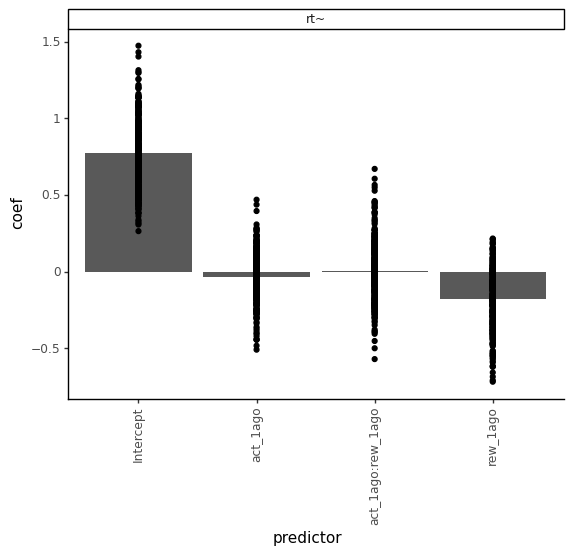

<ggplot: (170726478376)>

In [93]:
g = (gg.ggplot(all_model_results, gg.aes('predictor', 'coef'))
     + gg.stat_summary(geom='bar')
     + gg.geom_point()
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.facet_grid('~ model')
    )
g

In [94]:
# Add measures as column
all_model_results = all_model_results_raw.reset_index(
    ).rename(columns={'index': 'predictor'})

# Add general predictor columns
all_model_results['pred'] = all_model_results.predictor.apply(lambda x : x[:5])
all_model_results['n_ago'] = all_model_results.predictor.apply(lambda x : np.nan if (len(x) < 4) or (x[-4] in ['c', 'u']) else int(x[-4]))

# Add sigmoid columns
all_model_results = all_model_results.loc[(all_model_results.coef > -200) & (all_model_results.coef < 200)]  # exclude crazy values
all_model_results['sig_coef'] = sigmoid(all_model_results.coef)

# Add animal columns
all_model_results['sex'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'sex'))
all_model_results['agegroup'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'agegroup'))
all_model_results['age'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'age'))
all_model_results['animal'] = all_model_results.fullID.apply(lambda x : get_info_from_fullID(x, 'animal'))

for ani in np.unique(all_model_results.animal):
    all_model_results.loc[all_model_results.animal == ani, 'session'] = get_session(
        all_model_results.loc[all_model_results.animal == ani])  # needs to be within loops over animals
all_model_results['meta'] = add_meta_column(all_model_results)  # needs session column

# Check it out
all_model_results[:30]

,predictor,p,coef,ci_low,ci_high,fullID,model,pred,n_ago,sig_coef,sex,agegroup,age,animal,session,meta
0,Intercept,1.994899e-01,0.464766,-0.245227,1.174759,107511,action~,Inter,NaN,0.614144,Male,Adult,75,1,0.0,1-3
1,rt,1.019353e-01,-0.880419,-1.935476,0.174637,107511,action~,rt,NaN,0.293091,Male,Adult,75,1,0.0,1-3
2,reward_1ago,3.441716e-05,5.364792,2.826260,7.903324,107511,action~,rewar,1.0,0.995343,Male,Adult,75,1,0.0,1-3
3,norew_1ago,6.547042e-01,0.201412,-0.681253,1.084077,107511,action~,norew,1.0,0.550183,Male,Adult,75,1,0.0,1-3
4,reward_2ago,3.582039e-02,1.773556,0.117448,3.429664,107511,action~,rewar,2.0,0.854899,Male,Adult,75,1,0.0,1-3
5,norew_2ago,2.851616e-02,-1.032622,-1.956731,-0.108513,107511,action~,norew,2.0,0.262576,Male,Adult,75,1,0.0,1-3
6,reward_3ago,6.474044e-01,-0.399248,-2.110137,1.311642,107511,action~,rewar,3.0,0.401493,Male,Adult,75,1,0.0,1-3
7,norew_3ago,5.514173e-02,-1.361071,-2.752097,0.029955,107511,action~,norew,3.0,0.204066,Male,Adult,75,1,0.0,1-3
8,reward_4ago,5.744018e-02,1.512762,-0.047787,3.073311,107511,action~,rewar,4.0,0.819470,Male,Adult,75,1,0.0,1-3
9,norew_4ago,7.592282e-01,-0.220594,-1.631242,1.190054,107511,action~,norew,4.0,0.445074,Male,Adult,75,1,0.0,1-3


In [95]:
# Save as csv
all_model_results.to_csv(os.path.join(mouse_data_dir, 'all_model_results.csv'))

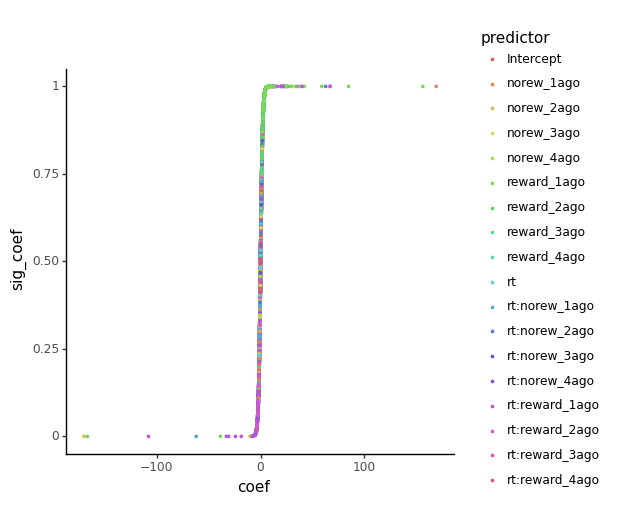

<ggplot: (170726729581)>

In [96]:
# Check out sigmoided coefficients
gg.options.figure_size = (5, 5)
g = (gg.ggplot(all_model_results, gg.aes('coef', 'sig_coef', color='predictor'))
     + gg.geom_point(size=0.5)
     + gg.coord_cartesian(ylim=(0, 1))
    )
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_sig_coefs.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.


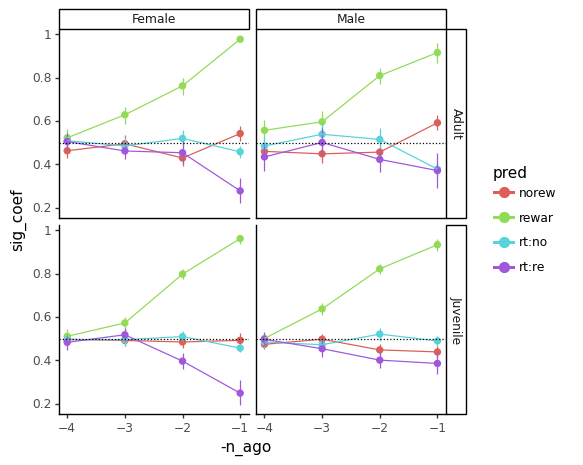

<ggplot: (170726729515)>

In [97]:
# Plot coefficients
g = (gg.ggplot(all_model_results, gg.aes('-n_ago', 'sig_coef', color='pred'))
#      + gg.geom_point(position='jitter', alpha=0.3, size=0.3)
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.geom_hline(yintercept=0.5, linetype='dotted')
     + gg.facet_grid('agegroup ~ sex')
    )
g.save(os.path.join(plot_dir, '5_regression_sig_coefs.png'))
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 5 x 5 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\5_regression_coefs.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\layer.py:372: PlotnineWarning: stat_summary : Removed 756 rows containing non-finite values.


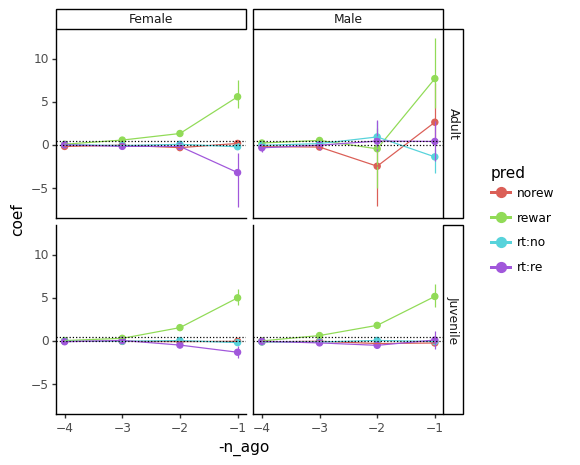

<ggplot: (170727754500)>

In [98]:
g2 = g + gg.aes(y='coef') + gg.geom_hline(yintercept=0, linetype='dotted')
g2.save(os.path.join(plot_dir, '5_regression_coefs.png'))
g2

## Predicting ITIs from previous actions and rewards

In [88]:
# Are ITIs predicted by previous trials?
# all_model_results_raw = pd.DataFrame()

# rew_norew_predictors = '(' + ' + '.join(['reward_{}ago + norew_{}ago'.format(i, i) for i in range(1, 5)]) + ')'
# formula = 'action ~ agegroup * rt * ' + rew_norew_predictors

formula = 'rt ~ C(agegroup) * (' + ' + '.join(['C(act_{}ago) * C(rew_{}ago)'.format(i, i) for i in range(1, 6)]) + ')'
# formula =  "action ~ reward_1ago + norew_1ago"
print(formula)

mod = smf.mixedlm(
    formula,
    true_dat,
    groups=true_dat['fullID'],
    missing='drop',
).fit()

print(mod.summary())
# mod = smf.logit(formula, sub_dat, ).fit()

# model_results = mod_fit_to_dataframe(mod)
# model_results['fullID'] = fullID
# model_results

rt ~ C(agegroup) * (C(act_1ago) * C(rew_1ago) + C(act_2ago) * C(rew_2ago) + C(act_3ago) * C(rew_3ago) + C(act_4ago) * C(rew_4ago) + C(act_5ago) * C(rew_5ago))
                                Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               rt          
No. Observations:                 189585                Method:                           REML        
No. Groups:                       383                   Scale:                            0.2506      
Min. group size:                  495                   Log-Likelihood:                   -138597.1583
Max. group size:                  495                   Converged:                        Yes         
Mean group size:                  495.0                                                               
------------------------------------------------------------------------------------------------------
                                                  

In [89]:
sum_dat = true_dat.groupby(['fullID', 'agegroup', 'rew_1ago', 'act_1ago']).aggregate('mean').reset_index().dropna()
sum_dat

,fullID,agegroup,rew_1ago,act_1ago,action,reward,rt,correct,trial,block,...,reward_15ago,norew_15ago,reward_16ago,norew_16ago,reward_17ago,norew_17ago,reward_18ago,norew_18ago,reward_19ago,norew_19ago
4,107511,Adult,0.0,0.0,0.364583,0.510417,0.606005,0.645833,258.125000,11.385417,...,-0.157895,0.063158,-0.105263,0.094737,-0.073684,0.126316,0.021277,0.063830,0.021277,0.042553
5,107511,Adult,0.0,1.0,0.641304,0.510870,0.574005,0.641304,258.576087,11.369565,...,0.011111,-0.122222,0.000000,-0.133333,-0.088889,-0.111111,-0.055556,-0.100000,-0.111111,0.044444
6,107511,Adult,1.0,0.0,0.012195,0.731707,0.496656,0.920732,245.445122,10.713415,...,0.235294,0.137255,0.263158,0.118421,0.298013,0.092715,0.251656,0.112583,0.293333,0.093333
7,107511,Adult,1.0,1.0,0.965986,0.653061,0.553891,0.897959,244.408163,10.605442,...,-0.204082,-0.129252,-0.265306,-0.122449,-0.272109,-0.129252,-0.312925,-0.115646,-0.326531,-0.170068
12,107611,Adult,0.0,0.0,0.305556,0.453704,0.648246,0.611111,242.518519,9.731481,...,-0.009709,-0.058252,0.019608,-0.078431,0.000000,0.000000,0.029412,0.009804,0.088235,0.009804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3051,3805812,Juvenile,1.0,1.0,1.000000,0.662162,0.587919,0.925676,265.939189,10.141892,...,-0.216216,-0.094595,-0.189189,-0.108108,-0.243243,-0.108108,-0.250000,-0.128378,-0.243243,-0.094595
3056,3806012,Juvenile,0.0,0.0,0.488889,0.433333,0.891790,0.622222,272.722222,10.511111,...,-0.069767,0.023256,-0.058140,0.034884,0.000000,0.000000,-0.034884,0.104651,0.046512,0.093023
3057,3806012,Juvenile,0.0,1.0,0.578431,0.470588,0.688588,0.696078,218.852941,8.098039,...,0.070707,-0.060606,0.040404,-0.030303,-0.040404,0.090909,-0.030303,0.000000,-0.090909,0.040404
3058,3806012,Juvenile,1.0,0.0,0.000000,0.709677,0.550090,0.929032,271.690323,10.419355,...,0.135135,0.108108,0.183673,0.122449,0.219178,0.095890,0.234483,0.075862,0.256944,0.090278


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


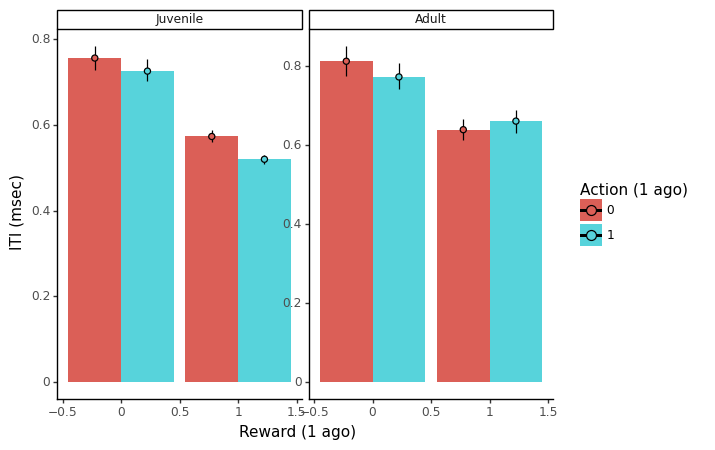

<ggplot: (170726491311)>

In [90]:
g = (gg.ggplot(sum_dat, gg.aes('(rew_1ago)', 'rt', fill='factor(act_1ago)'))
     + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
     + gg.stat_summary(geom='pointrange', position=gg.position_dodge(width=0.9))
     + gg.facet_wrap('~ agegroup', scales='free')
     + gg.labs(x='Reward (1 ago)', y='ITI (msec)', fill='Action (1 ago)')
    )
g

### Understanding why

In [ ]:
# Making sure everything is coded right:
    # no reward + left (0.0)  => norew -1, reward 0
    # no reward + right (1.0) => norew +1, reward 0
    #    reward + left (0.0)  => reward -1, norew 0
    #    reward + right (1.0) => reward +1, norew 0
true_dat.loc[:30, ['fullID', 'trial', 'reward', 'action', 'reward_1ago', 'norew_1ago', 'stay_1ago', 'stay_2ago', 'switch_1ago']]

In [ ]:
gg.options.figure_size = (1, 1)
sub_dat = true_dat.loc[true_dat.rt < 0.5]

for ago in range(1, 10):
    
    # Reward effect looks good: Mice choose left after left-reward, and right after right-reward
    gr = (gg.ggplot(sub_dat, gg.aes('reward_{}ago'.format(ago), 'action'))
         + gg.stat_summary()
         + gg.theme(legend_position='none')
         + gg.geom_hline(yintercept=0, linetype='dotted')
#          + gg.geom_hline(yintercept=1, linetype='dotted')
    )
    print(gr)

    # No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
    gn = gr + gg.aes('norew_{}ago'.format(ago))
    print(gn)

#     # Stay looks a little skewed too: Mice repeat right more than left
#     gs = gr + gg.aes('stay_{}ago'.format(ago))
#     print(gs)

gg.options.figure_size = (5, 5)

In [ ]:
gg.options.figure_size = (1, 1)

# Reward effect looks good: Mice choose left after left-reward, and right after right-reward
gr = (gg.ggplot(true_dat, gg.aes('factor(action)', 'reward_1ago'))
     + gg.stat_summary()
     + gg.theme(legend_position='none')
     + gg.labs(x='left right', y='left <-reward-> right')
)
print(gr)

# No reward effect looks wrong: Mice choose left after left-NO reward, and right after right-NO reward
gn = gr + gg.aes(y='norew_1ago')
print(gn)

# Stay looks a little skewed too: Mice repeat right more than left
gs = gr + gg.aes(y='stay_1ago')
print(gs)

gg.options.figure_size = (5, 5)

# OLD

In [ ]:
true_dat['session2'] = 2 * np.round(true_dat.session / 2)
true_dat['session3'] = 3 * np.round(true_dat.session / 3)
sub = true_dat[(true_dat.agegroup == "Juvenile")]
g = (gg.ggplot(sub, gg.aes('age', 'correct', color='factor(session)', group='factor(session)'))
     + gg.stat_summary()
     + gg.stat_summary(geom="line")
     + gg.facet_grid('~ gender')
    )
g

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high) * (true_dat.meta == '1-3')
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
    mean_dat,
).fit().summary())

In [ ]:
# Summarize data for regression
low, high = 1, 5
mean_dat = true_dat[
        (true_dat.trials2switch >= low) * (true_dat.trials2switch <= high)
    ].groupby(['fullID']).mean().reset_index()
mean_dat['gender'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['gender'][0])
mean_dat['agegroup'] = mean_dat.fullID.apply(lambda x : get_info_from_fullID(x)['agegroup'][0])

mean_dat['meta'] = np.nan
mean_dat.loc[mean_dat.session <= 2, 'meta'] = '1-3'
mean_dat.loc[(mean_dat.session >= 3) * (mean_dat.session <= 7), 'meta'] = '4-8'
mean_dat.loc[(mean_dat.session >= 8) * (mean_dat.session <= 10), 'meta'] = '9-11'
mean_dat = mean_dat.dropna(subset=['meta'])
mean_dat['meta'] = pd.Categorical(mean_dat['meta'], ordered=True, categories=('1-3', '4-8', '9-11'))
# mean_dat['meta'] = add_meta_column(mean_dat)
mean_dat

In [ ]:
# Agegroup differences in performace?
print(smf.ols(
    "correct ~ (trials2switch + session + gender + agegroup) * (trials2switch + session + gender + agegroup)",
#     "correct ~ gender + trials2switch + session + agegroup + session:agegroup + trials2switch:session:agegroup + trials2switch:session",
    mean_dat,
).fit().summary())

In [ ]:
# Age group difference in early sessions?
low, hig = 1, 6
sub_dat_t = true_dat[(true_dat.meta == '0-2') * (true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session + agegroup) * (trials2switch + gender + session + agegroup)",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

# Do adults do more meta-learning than juveniles?
sub_dat_t = true_dat[(true_dat.trials2switch >= low) * (true_dat.trials2switch < hig)]
print(smf.mixedlm(
    "correct ~ (trials2switch + gender + session) * (trials2switch + gender + session) * agegroup",
    sub_dat_t,
    groups=sub_dat_t["animal"]  # Default random effects structure: random intercept for each group
).fit().summary())

In [ ]:
import numpy as np                                                                                         
import statsmodels.api as sm                                                                               
import pandas as pd                                                                                        
                                                                                                           
# create fake data                                                                                         
# y: binary response                                                                                       
# x: continuous predictor                                                                                  
# re: three class random intercepts                                                                        
fakedata = pd.DataFrame({'y' : np.random.sample(50).round(),                                               
                         'x' : np.random.sample(50),                                                       
                         're' : (np.random.sample(50)*2).round().astype(int).astype(str)})
                                                          
# this is implemented as I understand the doc:                                                             
binom_model = sm.BinomialBayesMixedGLM(                                                                    
                                       fakedata['y'], # endog                                              
                                       fakedata['x'][:, None], # exog                                      
                                       pd.get_dummies(fakedata['re']), # Array of covariates for the random
                                       np.r_[0, 0, 0]) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()
print(binom_result.summary())

In [ ]:
fakedata

In [ ]:
import numpy as np                                                                                                              
import pandas as pd                                                                                                             
from statsmodels.genmod.bayes_mixed_glm import PoissonBayesMixedGLM, BinomialBayesMixedGLM                                      
                                                                                                                                
n = 1000                                                                                                                        
m = 50 # Number of groups                                                                                                       
grp = np.random.randint(0, m, n)                                                                                                
grp_efx = np.random.normal(size=m)                                                                                              
n_relapse_xmt = np.random.normal(size=n)                                                                                        
lpr = grp_efx[grp] + n_relapse_xmt                                                                                              
mn = np.exp(lpr)                                                                                                                
total_days_AU_MS = np.random.poisson(mn)                                                                                        
X = pd.DataFrame({"total_days_AU_MS": total_days_AU_MS,                                                                         
                  "f_id_site": grp,                                                                                             
                  "n_relapse_xmt": n_relapse_xmt})                                                                              
                                                                                                                                
formula = 'total_days_AU_MS ~ 1 + n_relapse_xmt'                                                                                
                                                                                                                                
glm_model = PoissonBayesMixedGLM.from_formula(formula=formula,                                                                  
                vc_formulas={'f_id_site': '0 + C(f_id_site)'}, data=X)                                                          
glm_results = glm_model.fit_map()                                                                                               
print(glm_results.summary())  

In [ ]:
print(smf.mixedlm(
    "correct ~ (agegroup + session + gender) * (agegroup + session + gender)",
    sub_dat,
    groups=sub_dat.animal
).fit().summary())

In [ ]:
# PC_sim_dir = "C:/Users/maria/MEGAsync/SLCNdata/ProbSwitch/PC_sim_dat"

In [ ]:
# # Define simulations to be analzed
# n_agents = 100
# PC_sim_name = [f for f in os.listdir(PC_sim_dir) if ('.csv' in f) and ('params' in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# print(model_names)

In [ ]:

# simulation_dir = os.path.join(PC_sim_dir, 'PC_{}_*.csv'.format(model_name, n_agents))
# if save_or_load_sim_mouse_dat == 'save':
#     sim_dat = pd.read_csv(simulation_dir)
#     sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
# else:
#     sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
# sim_dat = add_meta_column(sim_dat)
# sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))

# # Plot simulated data
# print("Plotting...")
# make_trials2switch_plot(sim_dat, suf='sim' + model_name)
# make_12ago_plot(sim_dat, 'sim' + model_name)
# make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
# make_block_correct_plot(sim_dat, 'sim' + model_name)
# make_session_correct_plot(sim_dat, 'sim' + model_name)
# make_age_reward_plot(sim_dat, 'sim' + model_name)

In [ ]:

# # model_names = [ 'Bbspr', 'Bbp', 'Bbpr', 'Bb', 'B', 'RLabcd', 'RLabcpd', 'RLabcpnd', 'RLabcpnxd', 'RLabd', 'RLabnp2d', 'RLab']

# # Read in and format simulated data
# # for PC_sim_name in PC_sim_names:
#     print("Model {}".format(model_name))
#     simulation_dir = os.path.join(PC_sim_dir, 'simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
#     if save_or_load_sim_mouse_dat == 'save':
#         sim_dat = pd.read_csv(simulation_dir)
#         sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
#     else:
#         sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))
#     sim_dat = add_meta_column(sim_dat)
#     sim_dat['agegroup'] = pd.Categorical(sim_dat['agegroup'], ordered=True, categories=('Juvenile', 'Adult'))
    
#     # Plot simulated data
#     print("Plotting...")
#     make_trials2switch_plot(sim_dat, suf='sim' + model_name)
#     make_12ago_plot(sim_dat, 'sim' + model_name)
#     make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
#     make_block_correct_plot(sim_dat, 'sim' + model_name)
#     make_session_correct_plot(sim_dat, 'sim' + model_name)
#     make_age_reward_plot(sim_dat, 'sim' + model_name)